# Second Model
The purpose of this notebook is to train models on training data generated after feature engineering in feature_engineering_sql.ipynb.

Importing packages:

In [1]:
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

Importing my written functions for KNN and Logistic Regression Modeling:

In [2]:
from logistic_reg_model_eval import *

In [3]:
from knn_model_eval import *

## Initial Modeling of the Training Data:

Reading in pickle of the training horses:

In [4]:
training_horses_2 = pd.read_pickle('./Data/training_horses_2.pkl')

### Initial Modeling of Training Horses - Logistic Regression

First, I want to plot some of the continuous features in my first model table (model_df) for show/no show, to see if there is much class separability:

In [5]:
training_horses_2.columns

Index(['race_id', 'horse_id', 'result', 'lengths_behind', 'horse_age',
       'horse_type', 'horse_country', 'horse_rating', 'horse_gear',
       'declared_weight', 'actual_weight', 'draw', 'finish_time', 'place_odds',
       'date', 'venue', 'config', 'surface', 'distance', 'show',
       'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths',
       'three_race_rolling_average_time',
       'three_race_rolling_average_distance_per_time', 'avg_field_rating',
       'field_rating_rank', 'diff_from_field_rating_avg', 'avg_field_age',
       'field_age_rank', 'diff_from_field_age_avg', 'avg_field_dec_wgts',
       'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank',
       'avg_field_actual_wgt', 'diff_from_field_handicap_wgt_avg',
       'field_handicap_wgt_rank', 'career_races', 'career_shows',
       'shows_in_last_5_races'],
      dtype='object')

Copying the training_horses_2 dataframe, just in case I make mistakes while working with it.

In [6]:
training_horses_2_copy = training_horses_2.copy()

### Data Cleaning:

In [7]:
training_horses_2_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63129 entries, 0 to 79446
Data columns (total 39 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   race_id                                       63129 non-null  int64  
 1   horse_id                                      63129 non-null  int64  
 2   result                                        63129 non-null  int64  
 3   lengths_behind                                63129 non-null  float64
 4   horse_age                                     63129 non-null  int64  
 5   horse_type                                    63127 non-null  object 
 6   horse_country                                 63127 non-null  object 
 7   horse_rating                                  63129 non-null  int64  
 8   horse_gear                                    63129 non-null  object 
 9   declared_weight                               63129 non-null 

Looking at my null values above, there are a few different situations to make situations on:
- horse_type/country: can fill these
- various metrics: these are based, mainly, on these horses not having run before. For the sake of the KNN and logistic regression models, I will drop those, although for some other models (forests, etc.) I should be able to keep them
- place_odds: I will keep these - odds are here to help calculate potential payoffs based on my models, but if a given observation doesn't have place_odds, it simply won't be bet on

### horse_type:

In [8]:
# training_horses_2_copy.horse_type.value_counts()

Similar to in initial_model_eda.ipynb, there are some different things going on here.  Will use my same decision:

**Decision: make horses that say color (Brown, Roan, Grey, or None) as "Gelding", since that is 90% of the horses in the set.**

In [9]:
# for i, value in enumerate(training_horses_2_copy['horse_type']):
#     if training_horses_2_copy.iloc[i, 5] == 'Brown':
#         training_horses_2_copy.iloc[i, 5] = "Gelding"
#     elif training_horses_2_copy.iloc[i, 5] == 'Roan':
#         training_horses_2_copy.iloc[i, 5] = "Gelding"
#     elif training_horses_2_copy.iloc[i, 5] == 'Grey':
#         training_horses_2_copy.iloc[i, 5] = "Gelding"

In [10]:
# #FIlling in any nan gender values with Gelding, for same rationale above.
# training_horses_2_copy.horse_type.fillna(value='Gelding', inplace=True)

In [11]:
# training_horses_2_copy.horse_type.value_counts()

In [12]:
# training_horses_2_copy.info()

horse_type is cleaned

### Horse_Country:

In [13]:
# training_horses_2_copy.horse_country.value_counts()

Checking out the two that are null:

In [14]:
# training_horses_2_copy[training_horses_2_copy.horse_country.isnull()]

Since this is horses 2645, I'll fill check to see if there's info from other races:

In [15]:
# training_horses_2_copy[training_horses_2_copy.horse_id == 2645]

There is not.  **DECISION: make country equal to AUS, since that is the most common country**.

In [16]:
# training_horses_2_copy.horse_country.fillna(value='AUS', inplace=True)

In [17]:
# training_horses_2_copy.info()

Country is cleaned.

### Place Odds:

In [18]:
# training_horses_2_copy[training_horses_2_copy.place_odds.isnull()]

Looks like there are various reaons for this, but since this is only going to be used as an extra calculation, I'll leave these in.  No reason to remove all of the rows.

### Various Feature Engineering Metrics

Likely, these are NaN since they are based on previous performance - i.e, a horse with no previous races has no previous stats.

In [19]:
# dummy_df = training_horses_2_copy[training_horses_2_copy.three_race_rolling_average_lengths.isnull()]

In [20]:
# dummy_df.sample(10)

Looks like they all have no career races - will double check with a value counter:

In [21]:
# dummy_df.career_races.value_counts()

In [22]:
# training_horses_2_copy.shape[0] - dummy_df.shape[0]

So these are all horses in their first career race, and based on the math above these account for all of the remaining rate-nulls.  **DECISION: REMOVE THESE ROWS**.  This is a good chunk of data at 3500+ rows, but in my opinion I wouldn't be betting smartly if I bet on a horse I had no previous race data on.  Thus, based on the use case these are ok to exclude from the model.

In [23]:
# training_horses_2_cleaned = training_horses_2_copy[training_horses_2_copy['three_race_rolling_average_lengths'].notna()]

In [24]:
# training_horses_2_cleaned.info()

In [25]:
# training_horses_2_cleaned.sample(10)

## Pickling Data, so i don't have to clean again.

Changing code to markdown after using once:

training_horses_2_cleaned.to_pickle("./Data/training_horses_2_cleaned.pkl")

Reading in the pickled data:

In [26]:
training_horses_2_cleaned = pd.read_pickle('./Data/training_horses_2_cleaned.pkl')

# Modeling

### One Hot Encoding of Gender (horse_type):

In [27]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [28]:
training_model_gender_cat = training_horses_2_cleaned.loc[:, ['horse_type']]

In [29]:
ohe.fit(training_model_gender_cat)

ohe_X = ohe.transform(training_model_gender_cat)

columns = ohe.get_feature_names(['horse_type'])

ohe_X_df = pd.DataFrame(ohe_X, columns=columns, index=training_model_gender_cat.index)

ohe_X_df.sample(20)

,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
29424,0.0,1.0,0.0,0.0,0.0
65051,0.0,1.0,0.0,0.0,0.0
35666,0.0,1.0,0.0,0.0,0.0
47142,0.0,1.0,0.0,0.0,0.0
9885,0.0,1.0,0.0,0.0,0.0
71099,0.0,1.0,0.0,0.0,0.0
55184,0.0,1.0,0.0,0.0,0.0
39534,0.0,1.0,0.0,0.0,0.0
4151,0.0,1.0,0.0,0.0,0.0
33776,0.0,1.0,0.0,0.0,0.0


Concatenating back into the original data frame:

In [30]:
comb_training_horses_2_cleaned = pd.concat([training_horses_2_cleaned, ohe_X_df], axis=1)

In [31]:
comb_training_horses_2_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_type,horse_country,horse_rating,horse_gear,declared_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,Gelding,AUS,92,TT/B,1172.0,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,Gelding,IRE,89,CP,1154.0,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,Gelding,GER,91,TT/B/H,1147.0,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,Gelding,AUS,87,TT/V,1191.0,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0
6,6348,985,7,2.25,5,Gelding,NZ,84,--,1070.0,...,-5.785714,12,28,8.0,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
#Removing original horse_type column:
comb_training_horses_2_cleaned.drop(columns='horse_type', inplace=True)
comb_training_horses_2_cleaned.head()

,race_id,horse_id,result,lengths_behind,horse_age,horse_country,horse_rating,horse_gear,declared_weight,actual_weight,...,diff_from_field_handicap_wgt_avg,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig
1,6348,1698,2,0.20,6,AUS,92,TT/B,1172.0,129,...,4.214286,4,36,13.0,2.0,0.0,1.0,0.0,0.0,0.0
3,6348,833,4,0.75,4,IRE,89,CP,1154.0,126,...,1.214286,7,19,9.0,2.0,0.0,1.0,0.0,0.0,0.0
4,6348,3368,5,1.25,3,GER,91,TT/B/H,1147.0,128,...,3.214286,5,4,4.0,4.0,0.0,1.0,0.0,0.0,0.0
5,6348,1238,6,1.25,5,AUS,87,TT/V,1191.0,122,...,-2.785714,10,25,12.0,1.0,0.0,1.0,0.0,0.0,0.0
6,6348,985,7,2.25,5,NZ,84,--,1070.0,119,...,-5.785714,12,28,8.0,0.0,0.0,1.0,0.0,0.0,0.0


OHE Complete.

### Feature Selection:

Adding one more feature for now - show rate (i.e. column career_shows / career_races):

In [33]:
comb_training_horses_2_cleaned['career_show_rate'] = comb_training_horses_2_cleaned['career_shows'] / comb_training_horses_2_cleaned['career_races']

In [34]:
comb_training_horses_2_cleaned.sample(5)

,race_id,horse_id,result,lengths_behind,horse_age,horse_country,horse_rating,horse_gear,declared_weight,actual_weight,...,field_handicap_wgt_rank,career_races,career_shows,shows_in_last_5_races,horse_type_Filly,horse_type_Gelding,horse_type_Horse,horse_type_Mare,horse_type_Rig,career_show_rate
74118,428,2053,9,3.75,3,NZ,60,--,1077.0,133,...,1,9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.111111
63635,1259,4105,7,3.75,3,SAF,60,--,1085.0,126,...,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
9786,5566,690,4,3.50,4,SAF,80,TT/B,1072.0,117,...,13,13,7.0,4.0,0.0,1.0,0.0,0.0,0.0,0.538462
73501,478,61,6,4.50,3,AUS,60,--,1197.0,116,...,4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
55047,1946,2130,9,5.75,3,NZ,60,--,1076.0,132,...,1,27,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.296296


In [35]:
comb_training_horses_2_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59605 entries, 1 to 79203
Data columns (total 44 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   race_id                                       59605 non-null  int64  
 1   horse_id                                      59605 non-null  int64  
 2   result                                        59605 non-null  int64  
 3   lengths_behind                                59605 non-null  float64
 4   horse_age                                     59605 non-null  int64  
 5   horse_country                                 59605 non-null  object 
 6   horse_rating                                  59605 non-null  int64  
 7   horse_gear                                    59605 non-null  object 
 8   declared_weight                               59605 non-null  float64
 9   actual_weight                                 59605 non-null 

Using the following columns:
- Features - Numerical: horse_age, declared_weight, actual_weight, horse_rating, draw, three_race_rolling_avg_finish, three_race_rolling_average_lengths, three_race_rolling_average_time, three_race_rolling_average_distance_per_time, field_rating_rank, diff_from_field_rating_avg, field_age_rank, diff_from_field_age_avg, diff_from_field_declared_wgt_avg, field_dec_wgt_rank, diff_from_field_handicap_wgt_avg, field_handicap_wgt_rank, career_races, career_shows, shows_in_last_5_races, career_show_rate
- Features - Categorical: horse_type_Filly, horse_type_Gelding, horse_type_Horse, horse_type_Mare, horse_type_Rig
- Target - show

In [36]:
columns_1 = ['horse_age', 'declared_weight', 'actual_weight', 'horse_rating', 'draw', 'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths', 'three_race_rolling_average_time', 'three_race_rolling_average_distance_per_time', 'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 'career_races', 'career_shows', 'shows_in_last_5_races', 'career_show_rate', 'horse_type_Filly', 'horse_type_Gelding', 'horse_type_Horse', 'horse_type_Mare', 'horse_type_Rig']

In [37]:
for i, feature in enumerate(columns_1, 1):
    print("Feature {}: {}".format(i, feature))

Feature 1: horse_age
Feature 2: declared_weight
Feature 3: actual_weight
Feature 4: horse_rating
Feature 5: draw
Feature 6: three_race_rolling_avg_finish
Feature 7: three_race_rolling_average_lengths
Feature 8: three_race_rolling_average_time
Feature 9: three_race_rolling_average_distance_per_time
Feature 10: field_rating_rank
Feature 11: diff_from_field_rating_avg
Feature 12: field_age_rank
Feature 13: diff_from_field_age_avg
Feature 14: diff_from_field_declared_wgt_avg
Feature 15: field_dec_wgt_rank
Feature 16: diff_from_field_handicap_wgt_avg
Feature 17: field_handicap_wgt_rank
Feature 18: career_races
Feature 19: career_shows
Feature 20: shows_in_last_5_races
Feature 21: career_show_rate
Feature 22: horse_type_Filly
Feature 23: horse_type_Gelding
Feature 24: horse_type_Horse
Feature 25: horse_type_Mare
Feature 26: horse_type_Rig


In [38]:
X = comb_training_horses_2_cleaned[columns_1]
y = comb_training_horses_2_cleaned['show']

## Pairplots

In [39]:
# sns.pairplot(comb_training_horses_2_cleaned[['result', 'lengths_behind', 'horse_age', 'declared_weight', 'actual_weight', 'horse_rating', 'draw', 'three_race_rolling_avg_finish', 'three_race_rolling_average_lengths', 'three_race_rolling_average_time', 'three_race_rolling_average_distance_per_time', 'field_rating_rank', 'diff_from_field_rating_avg', 'field_age_rank', 'diff_from_field_age_avg', 'diff_from_field_declared_wgt_avg', 'field_dec_wgt_rank', 'diff_from_field_handicap_wgt_avg', 'field_handicap_wgt_rank', 'career_races', 'career_shows', 'shows_in_last_5_races', 'career_show_rate', 'show']], corner=True, height=1.5, plot_kws={'size': 3}, hue='show');

None have particularly good separability.

### KNN Model:

The accuracy score for kNN is
Training:  76.98%
Validation set:  75.76%
Validation Set F1 Score: 0.1963:
Validation Set Fbeta Score (beta=0.5): 0.3113
Validation set Precision: 0.5109
Validation set recall: 0.1215 

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      9016
           1       0.51      0.12      0.20      2905

    accuracy                           0.76     11921
   macro avg       0.64      0.54      0.53     11921
weighted avg       0.71      0.76      0.70     11921



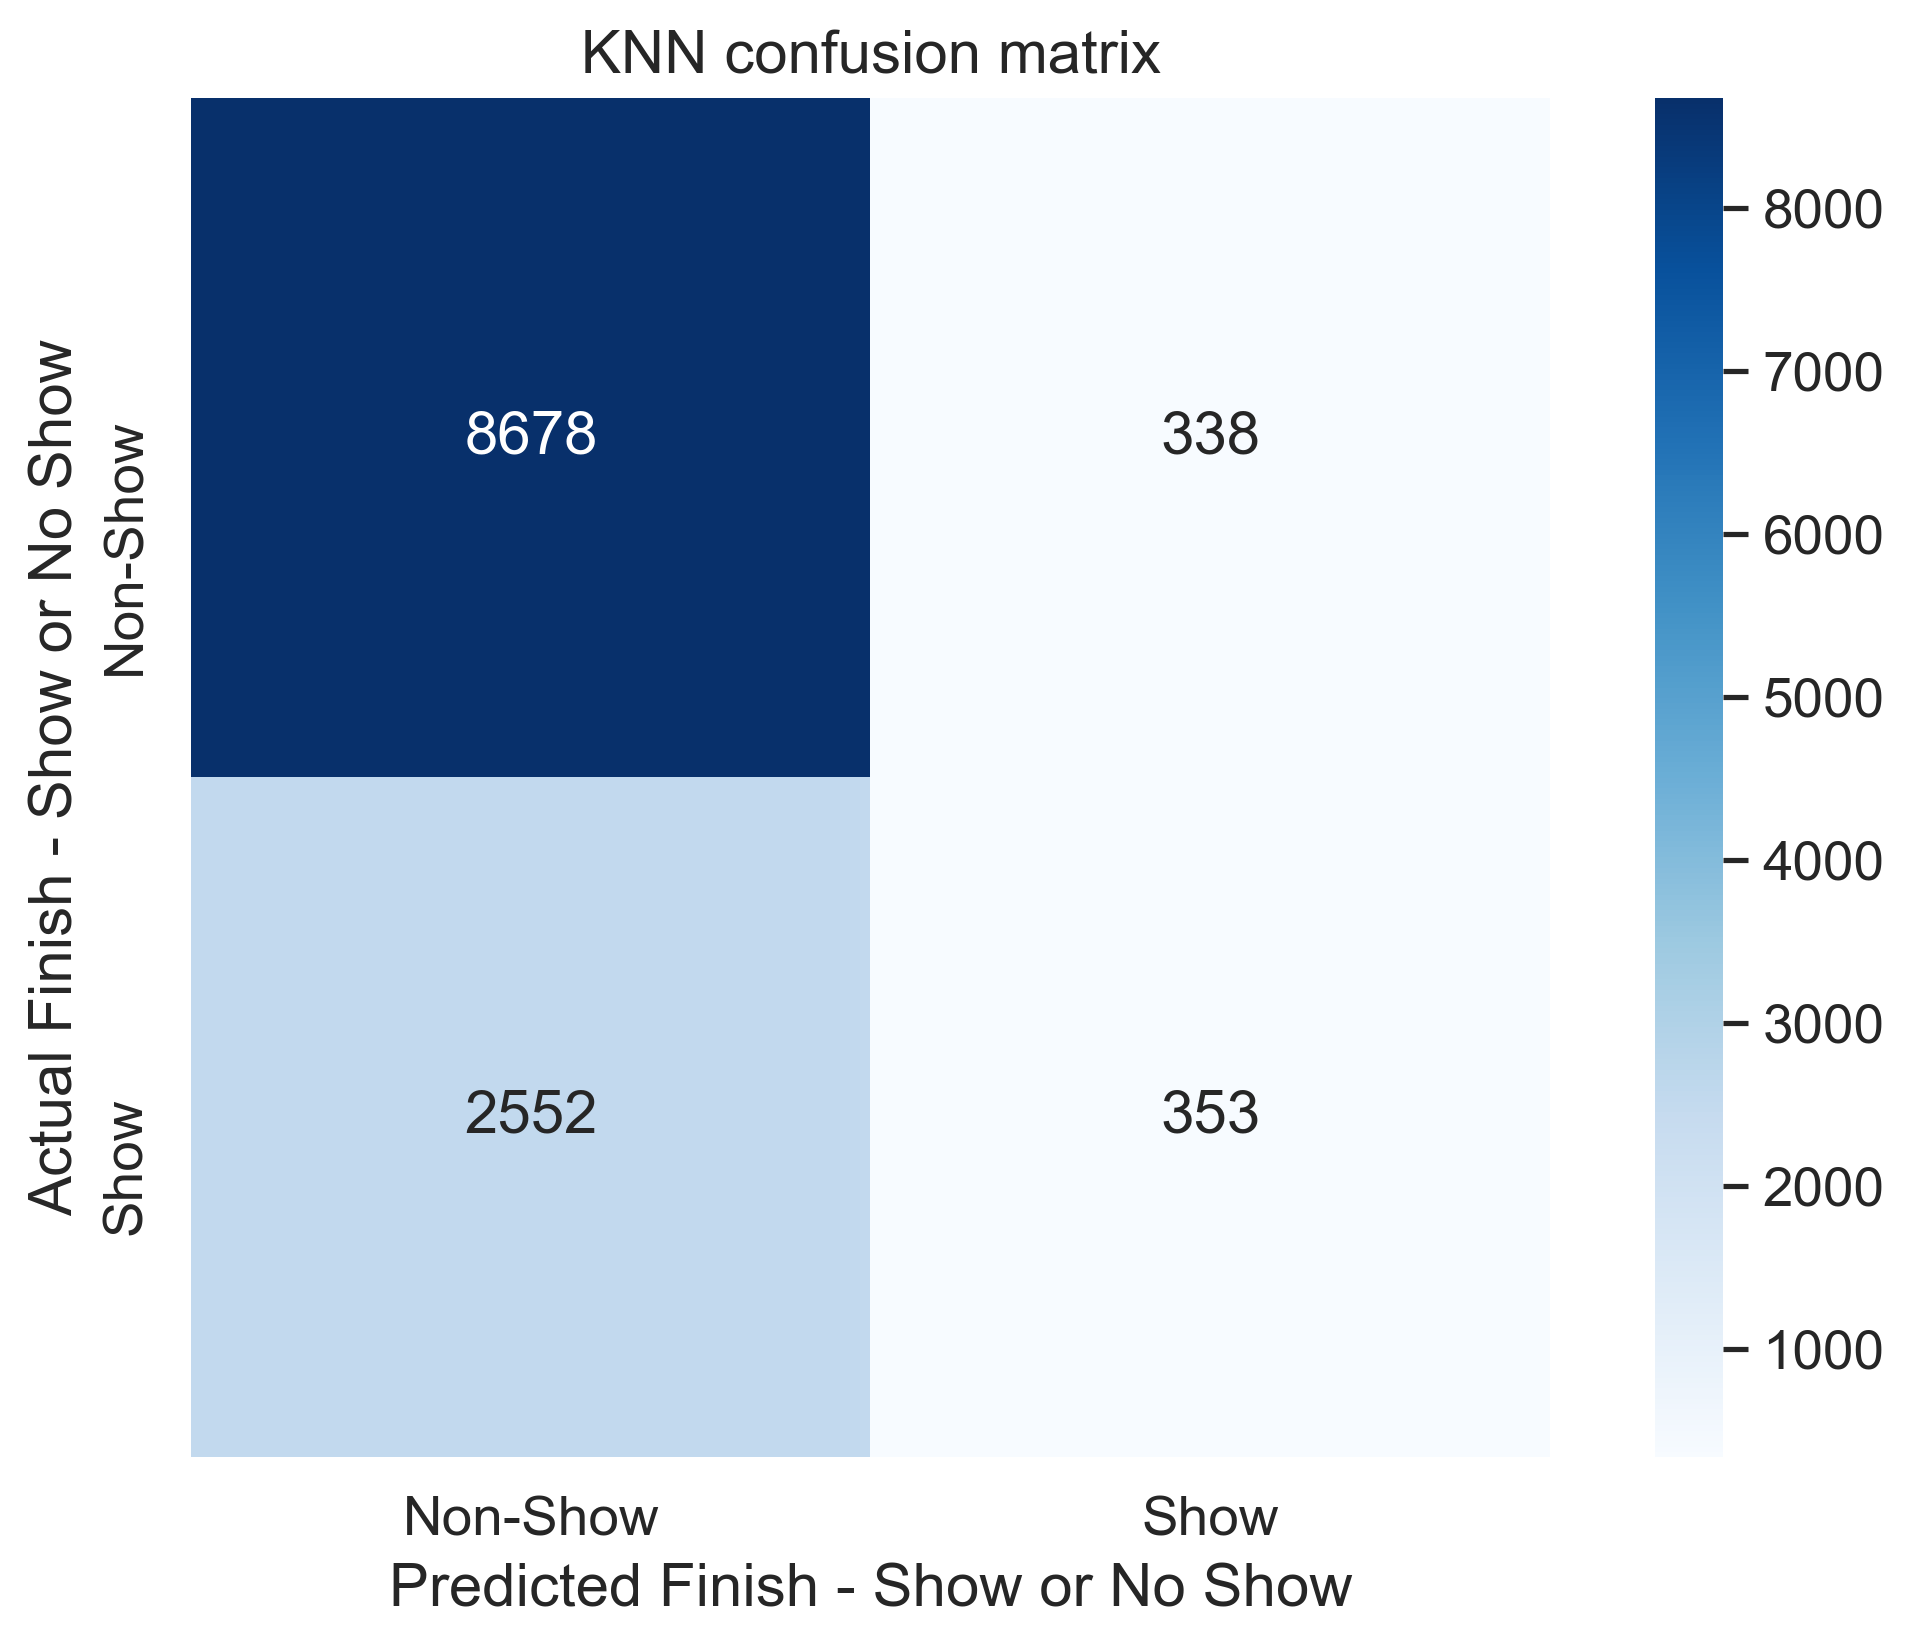

In [40]:
KNN_accuracy_scorer(X, y, n = 21)

## Logistic Regression:

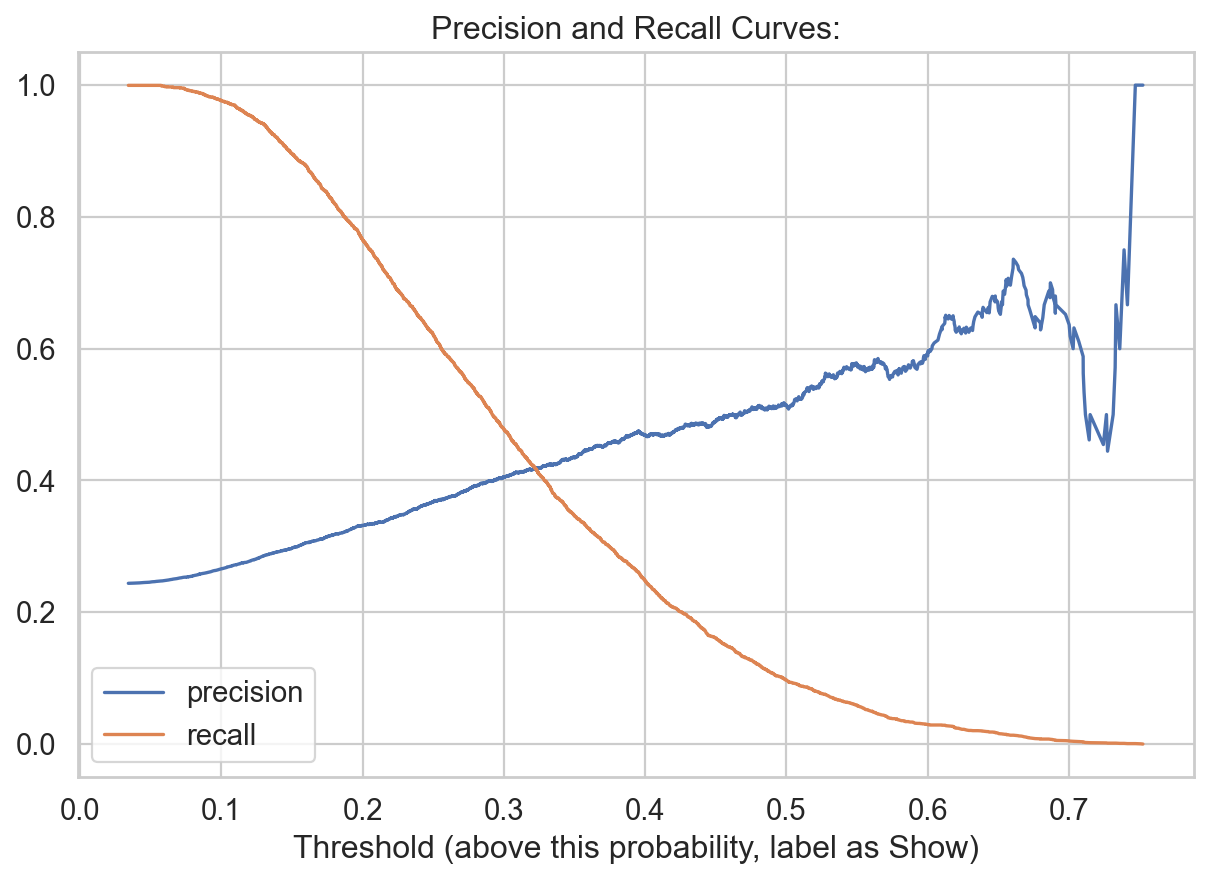

In [41]:
log_precision_and_recall_curves(X,y,C=1)

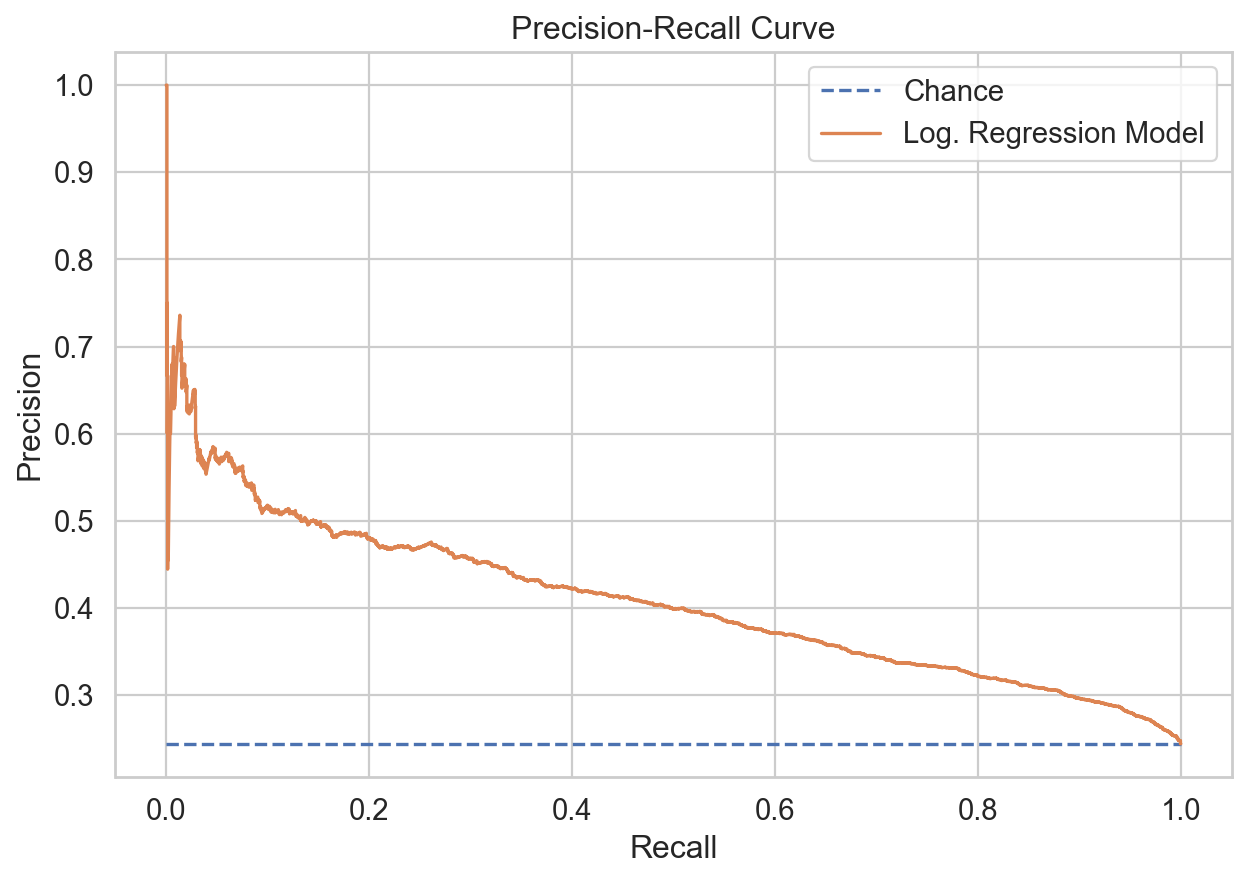

In [42]:
log_precision_recall_curve_generator(X,y,C=1)

ROC AUC score =  0.6939502082356552
Optimal Threshold: 0.2508
Threshold for Max Precision: 0.0341


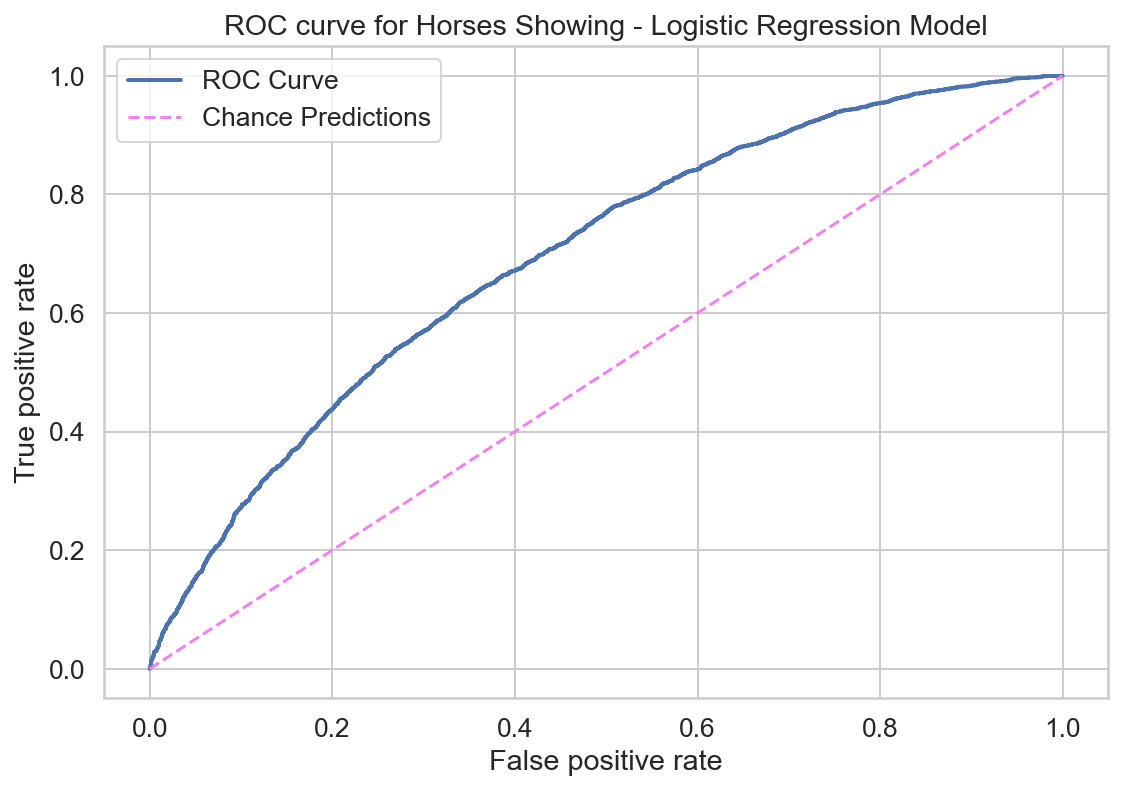

In [43]:
log_roc_curve_generator(X,y,C=1)

The accuracy score for logistic regression w/ threshold of 0.2508 is:
Validation set accuracy:  64.97%
Additional Model Metrics:
Validation Set F1 Score: 0.4627:
Validation Set Fbeta Score (beta=0.5): 0.4018
Validation set Precision: 0.3694
Validation set recall: 0.6189 

Validation set log-loss score: 12.0994
Confusion Matrix, Threshold = 0.2508


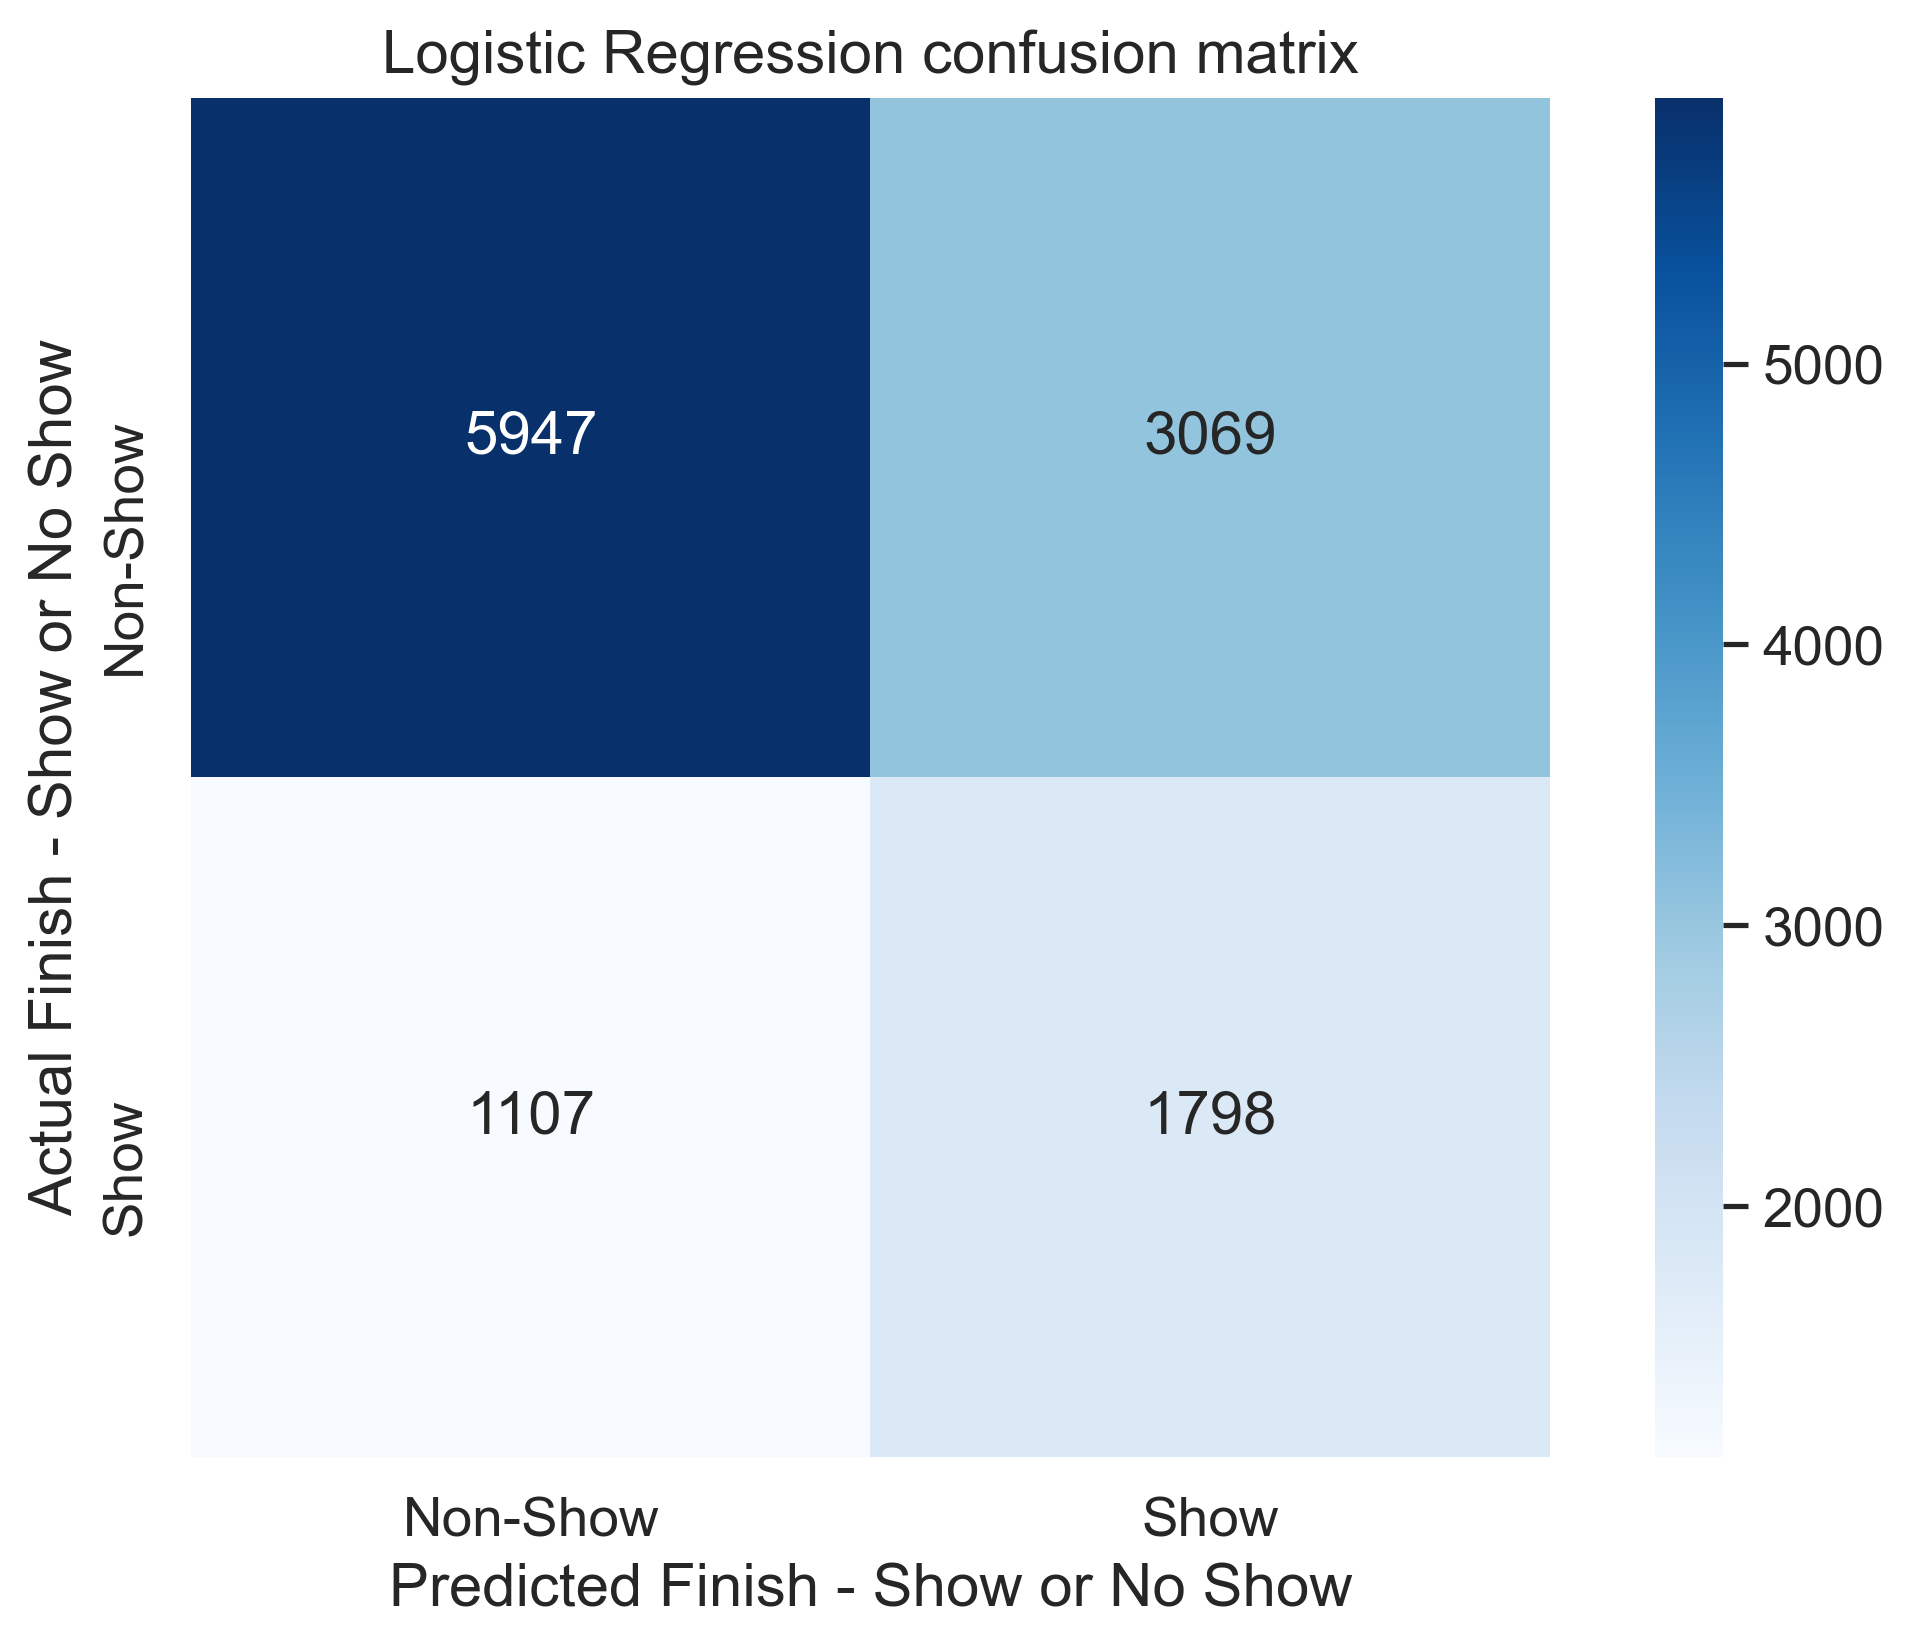

In [44]:
log_accuracy_scorer(X, y, threshold=0.2508, C=1, beta=0.5)

Running at multiple values of C:

In [45]:
C_list = [0.1, 0.5, 1, 5, 10]

The accuracy score for logistic regression w/ threshold of 0.2508 is:
Validation set accuracy:  64.94%
Additional Model Metrics:
Validation Set F1 Score: 0.4621:
Validation Set Fbeta Score (beta=0.5): 0.4014
Validation set Precision: 0.3690
Validation set recall: 0.6179 

Validation set log-loss score: 12.1080
Confusion Matrix, Threshold = 0.2508
The accuracy score for logistic regression w/ threshold of 0.2508 is:
Validation set accuracy:  64.99%
Additional Model Metrics:
Validation Set F1 Score: 0.4628:
Validation Set Fbeta Score (beta=0.5): 0.4020
Validation set Precision: 0.3696
Validation set recall: 0.6189 

Validation set log-loss score: 12.0936
Confusion Matrix, Threshold = 0.2508
The accuracy score for logistic regression w/ threshold of 0.2508 is:
Validation set accuracy:  64.97%
Additional Model Metrics:
Validation Set F1 Score: 0.4627:
Validation Set Fbeta Score (beta=0.5): 0.4018
Validation set Precision: 0.3694
Validation set recall: 0.6189 

Validation set log-loss score

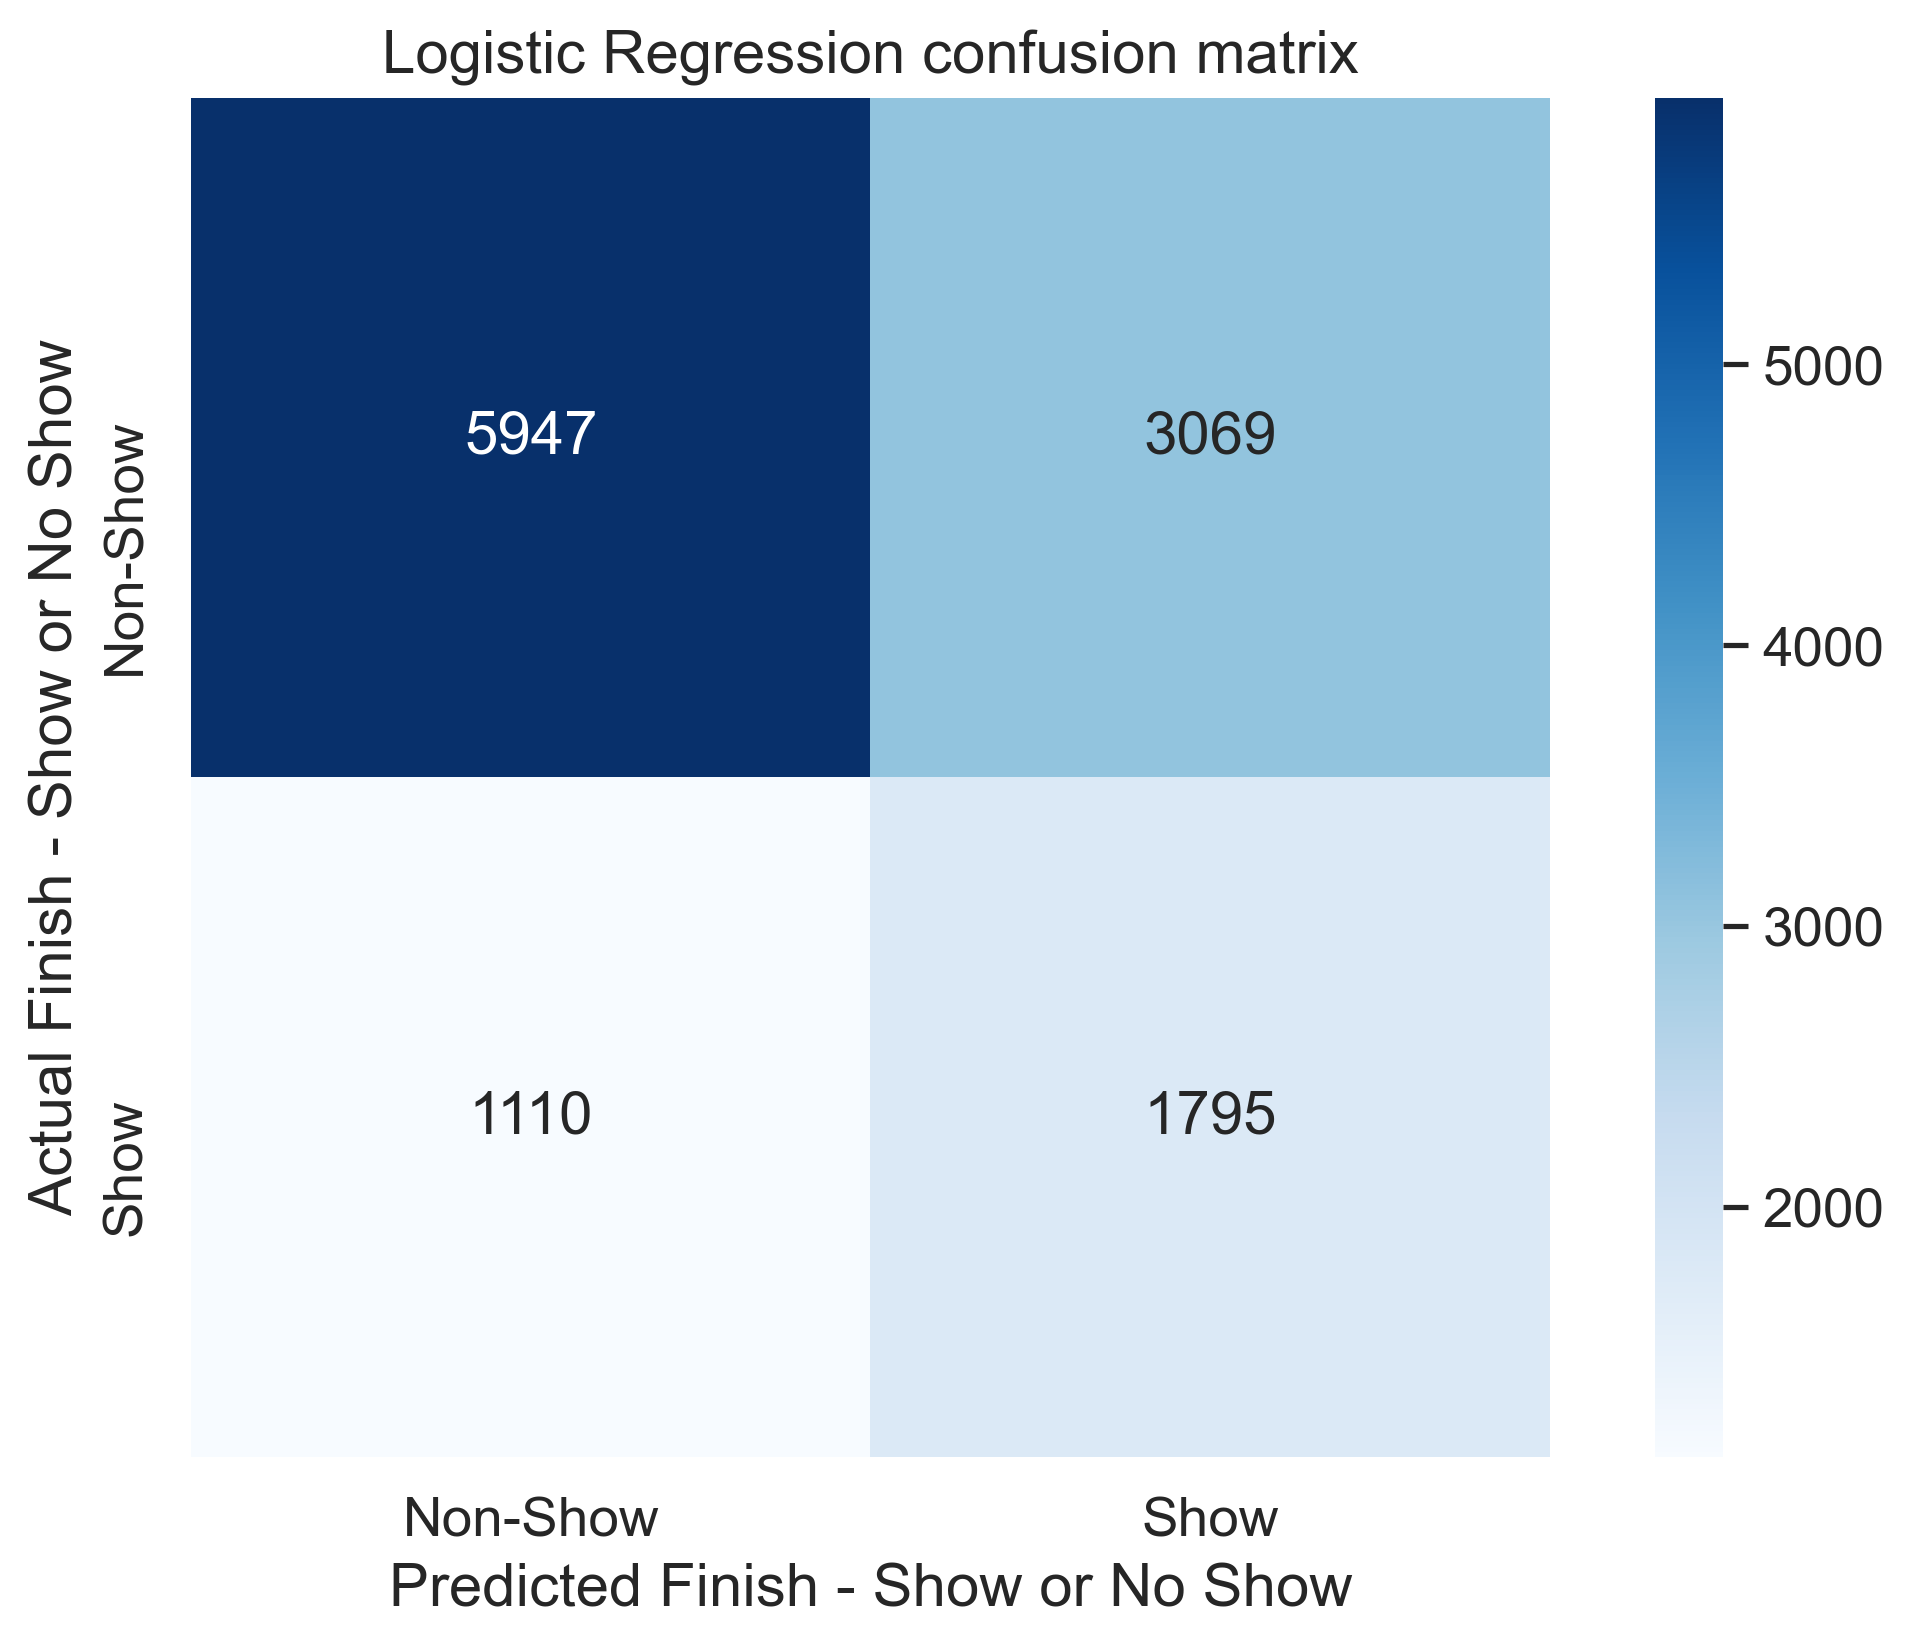

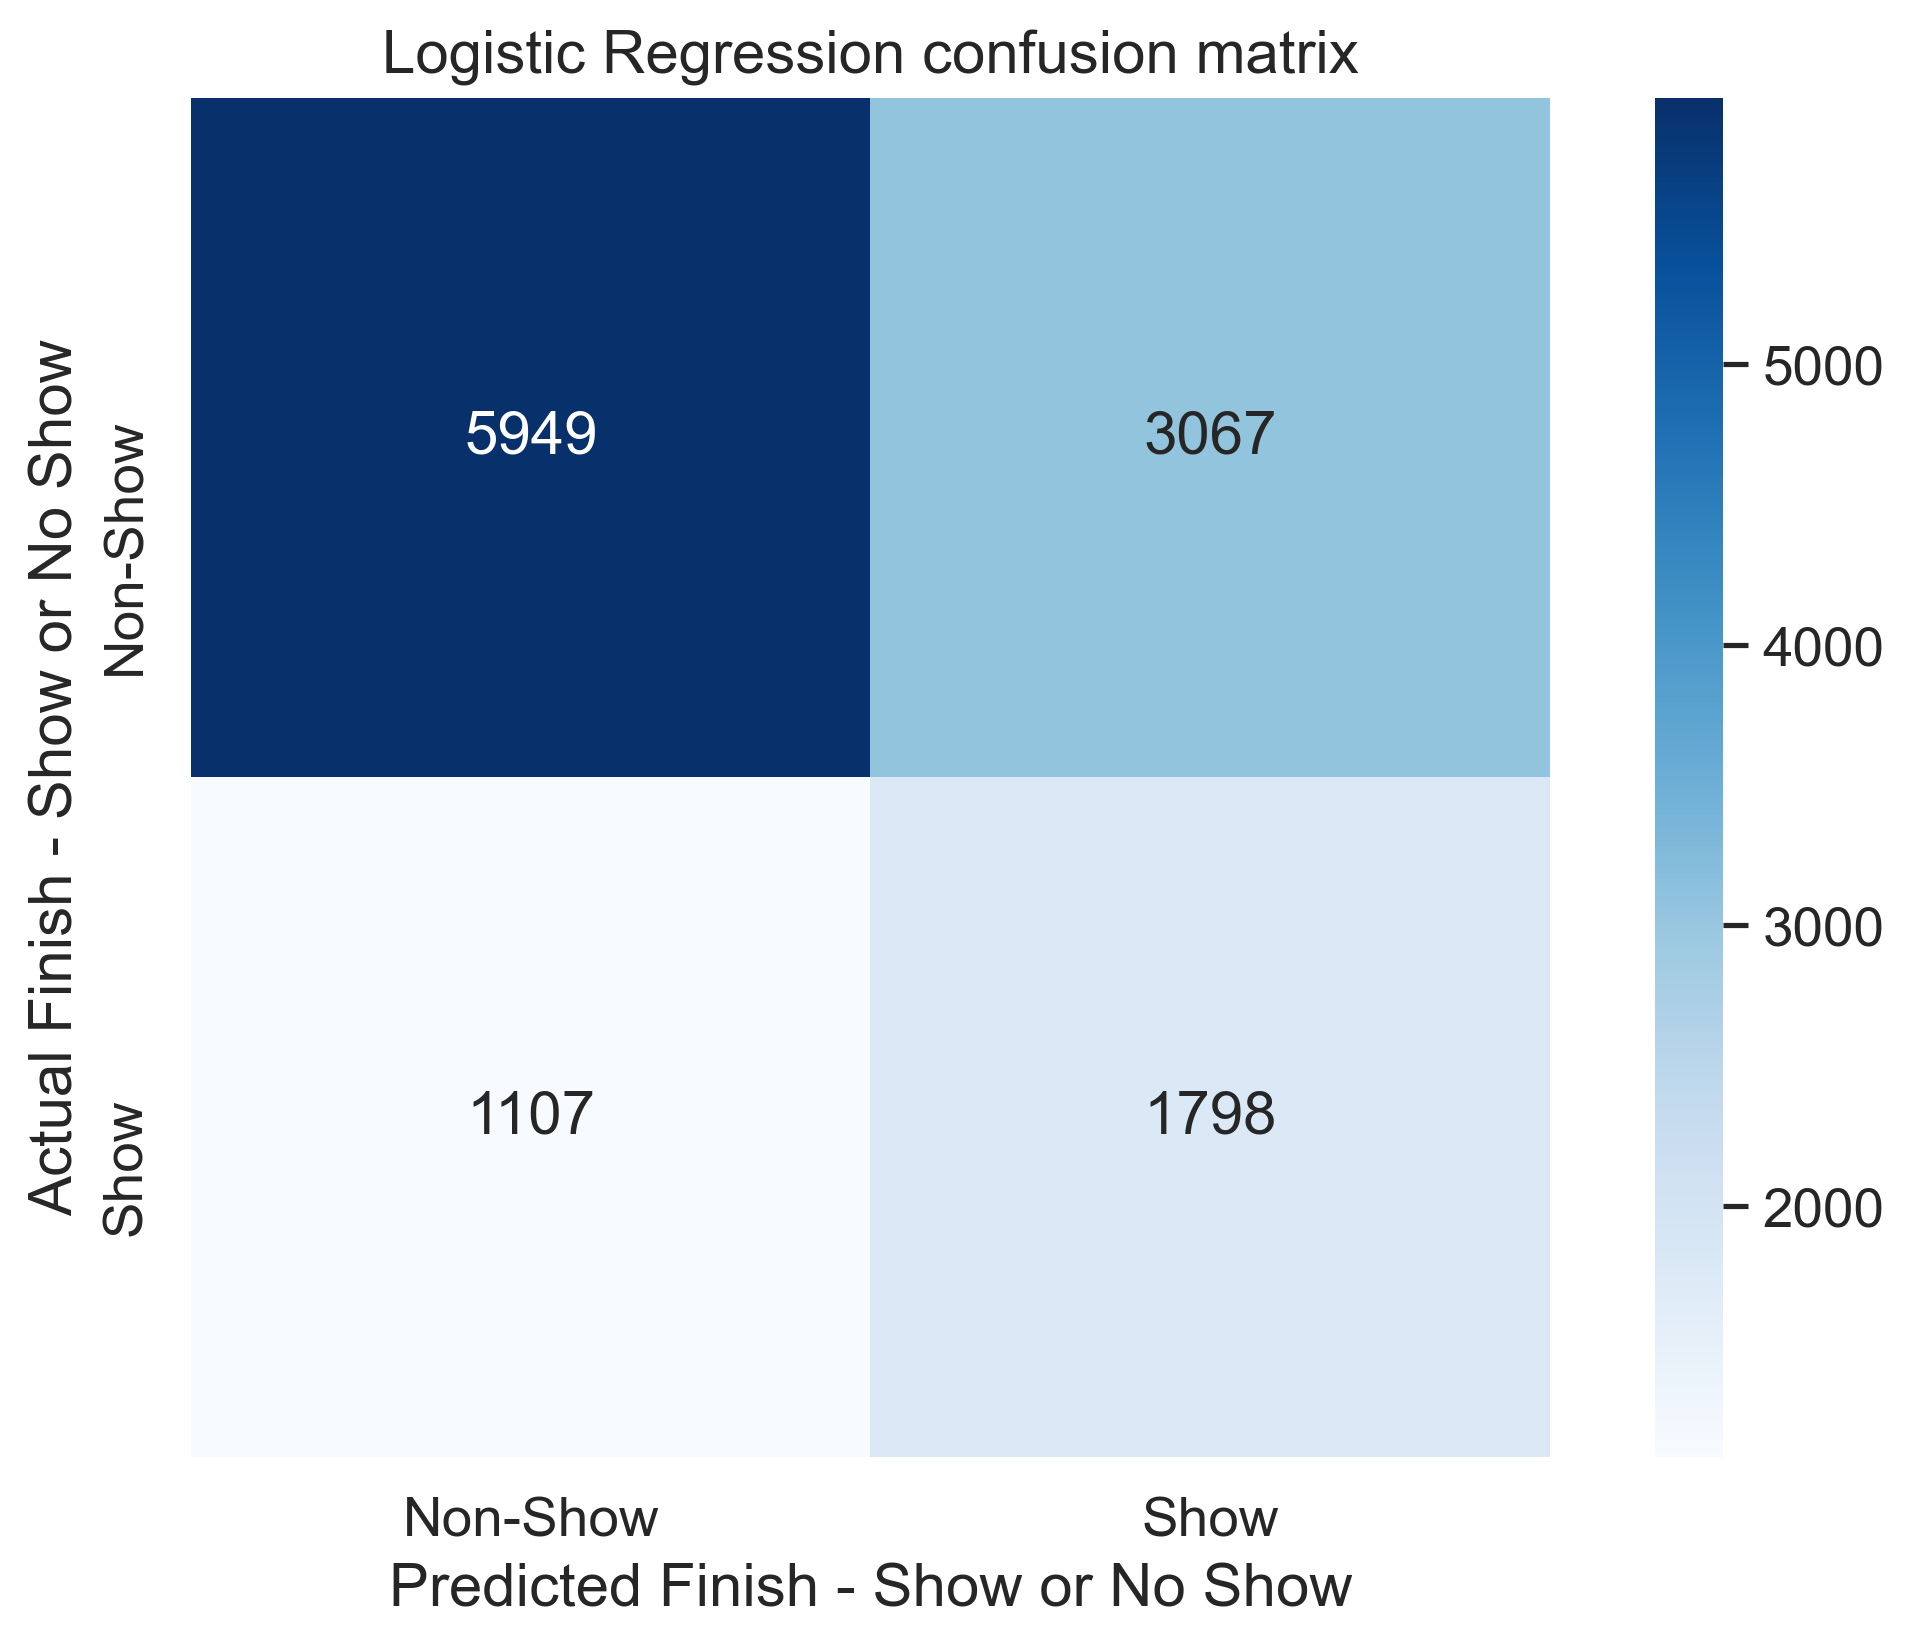

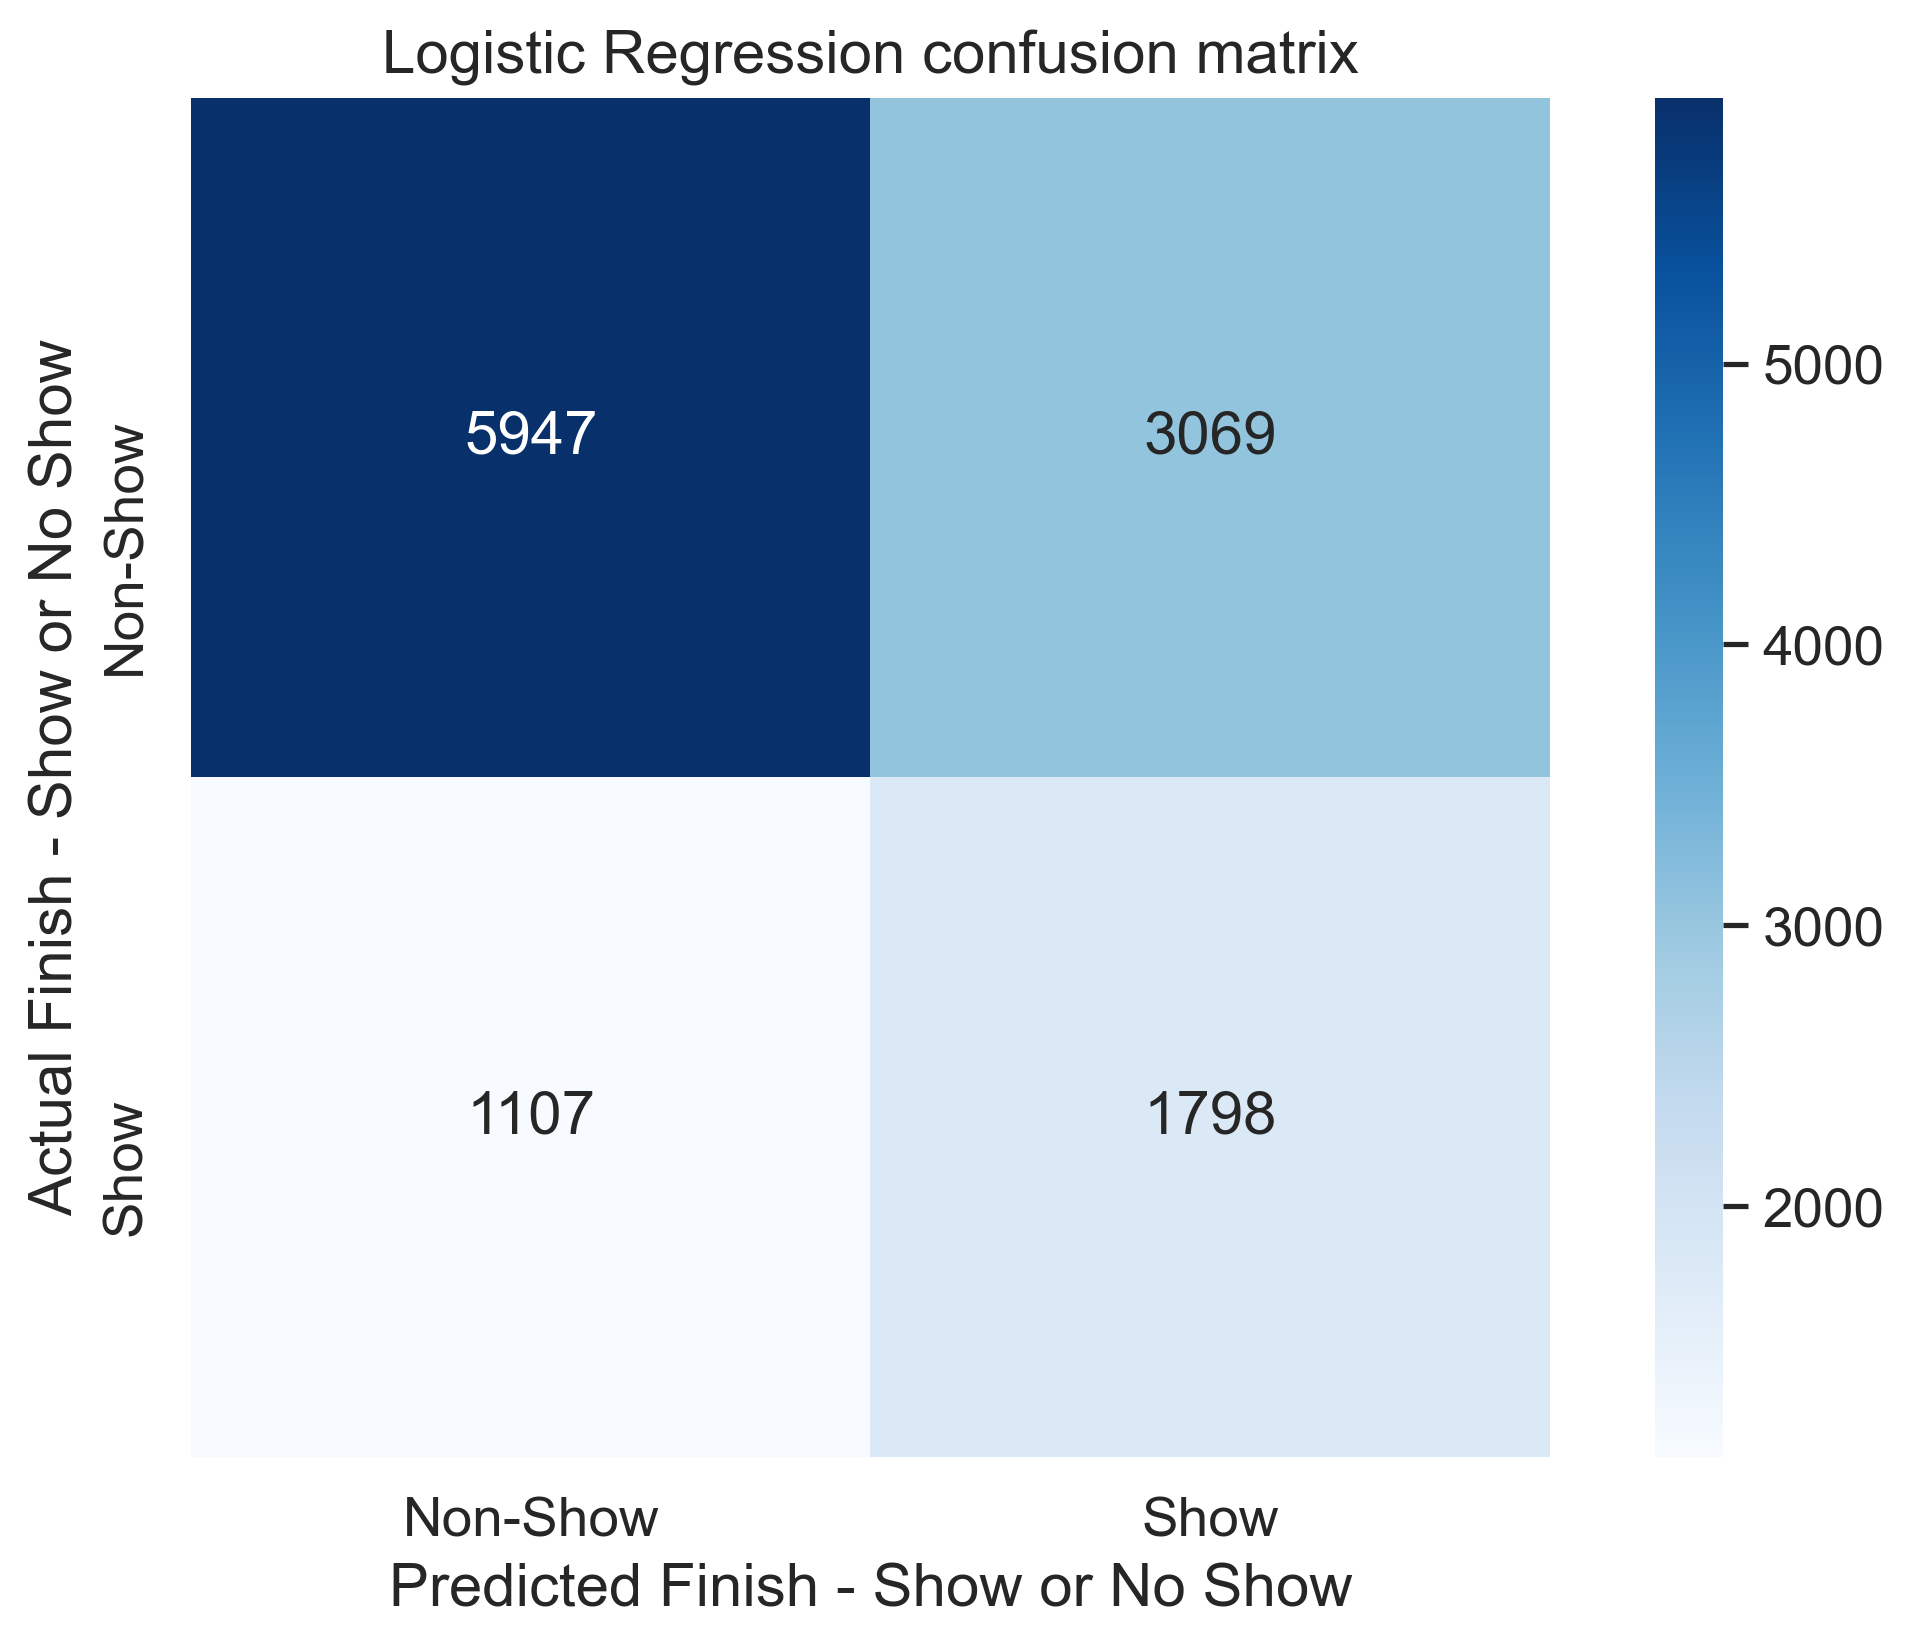

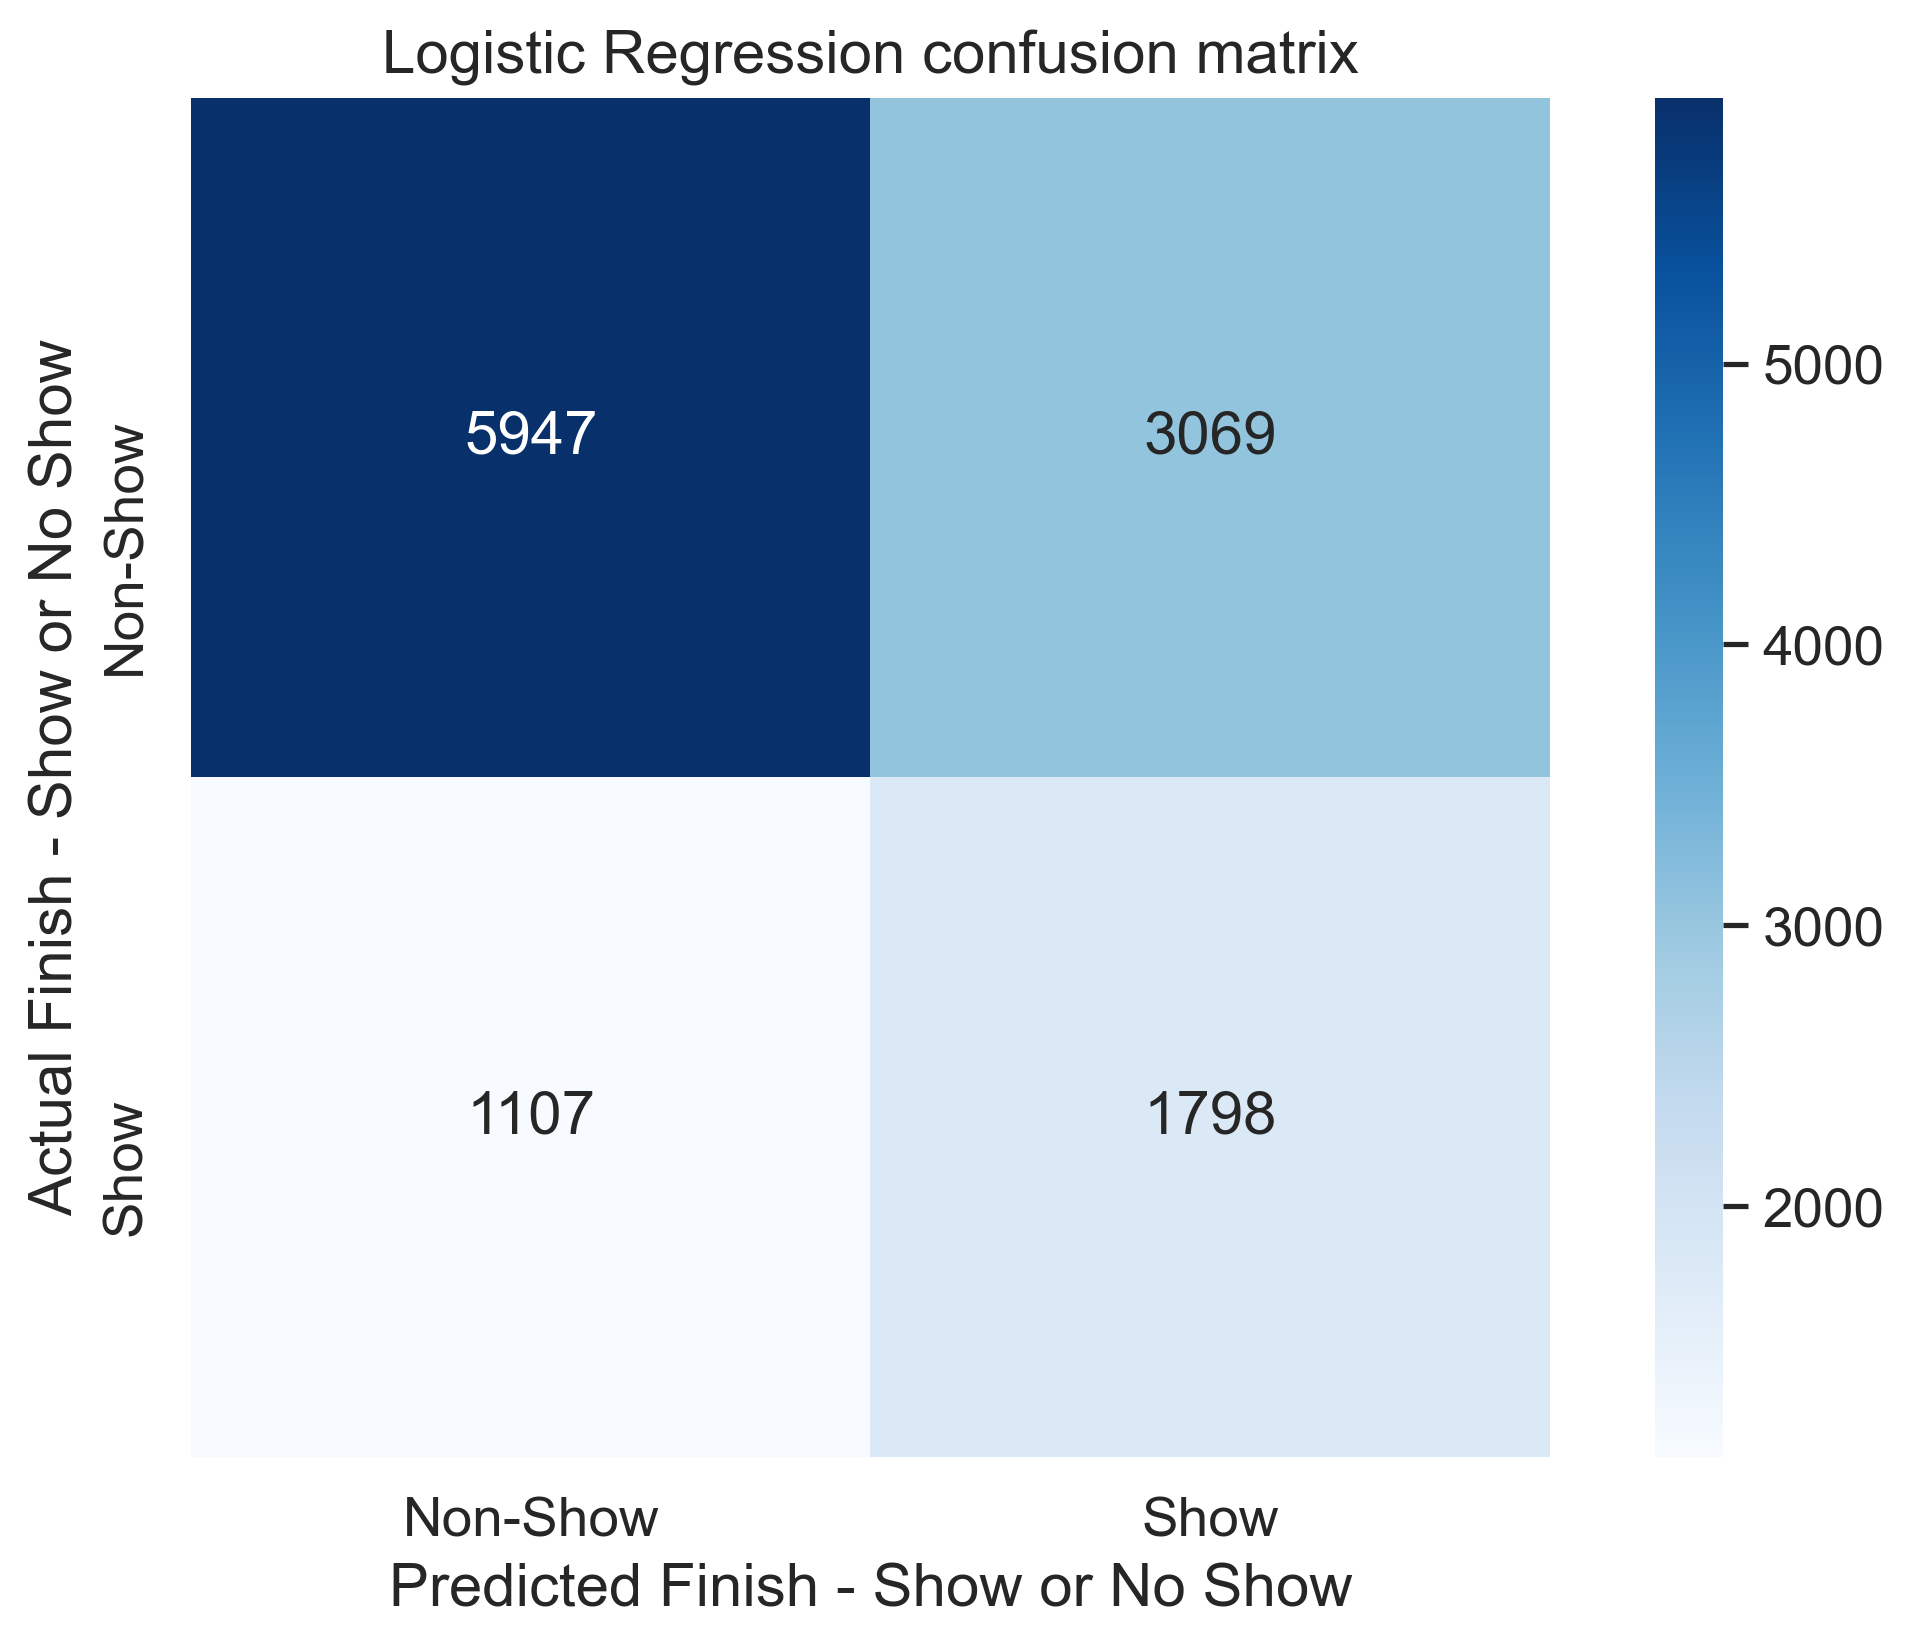

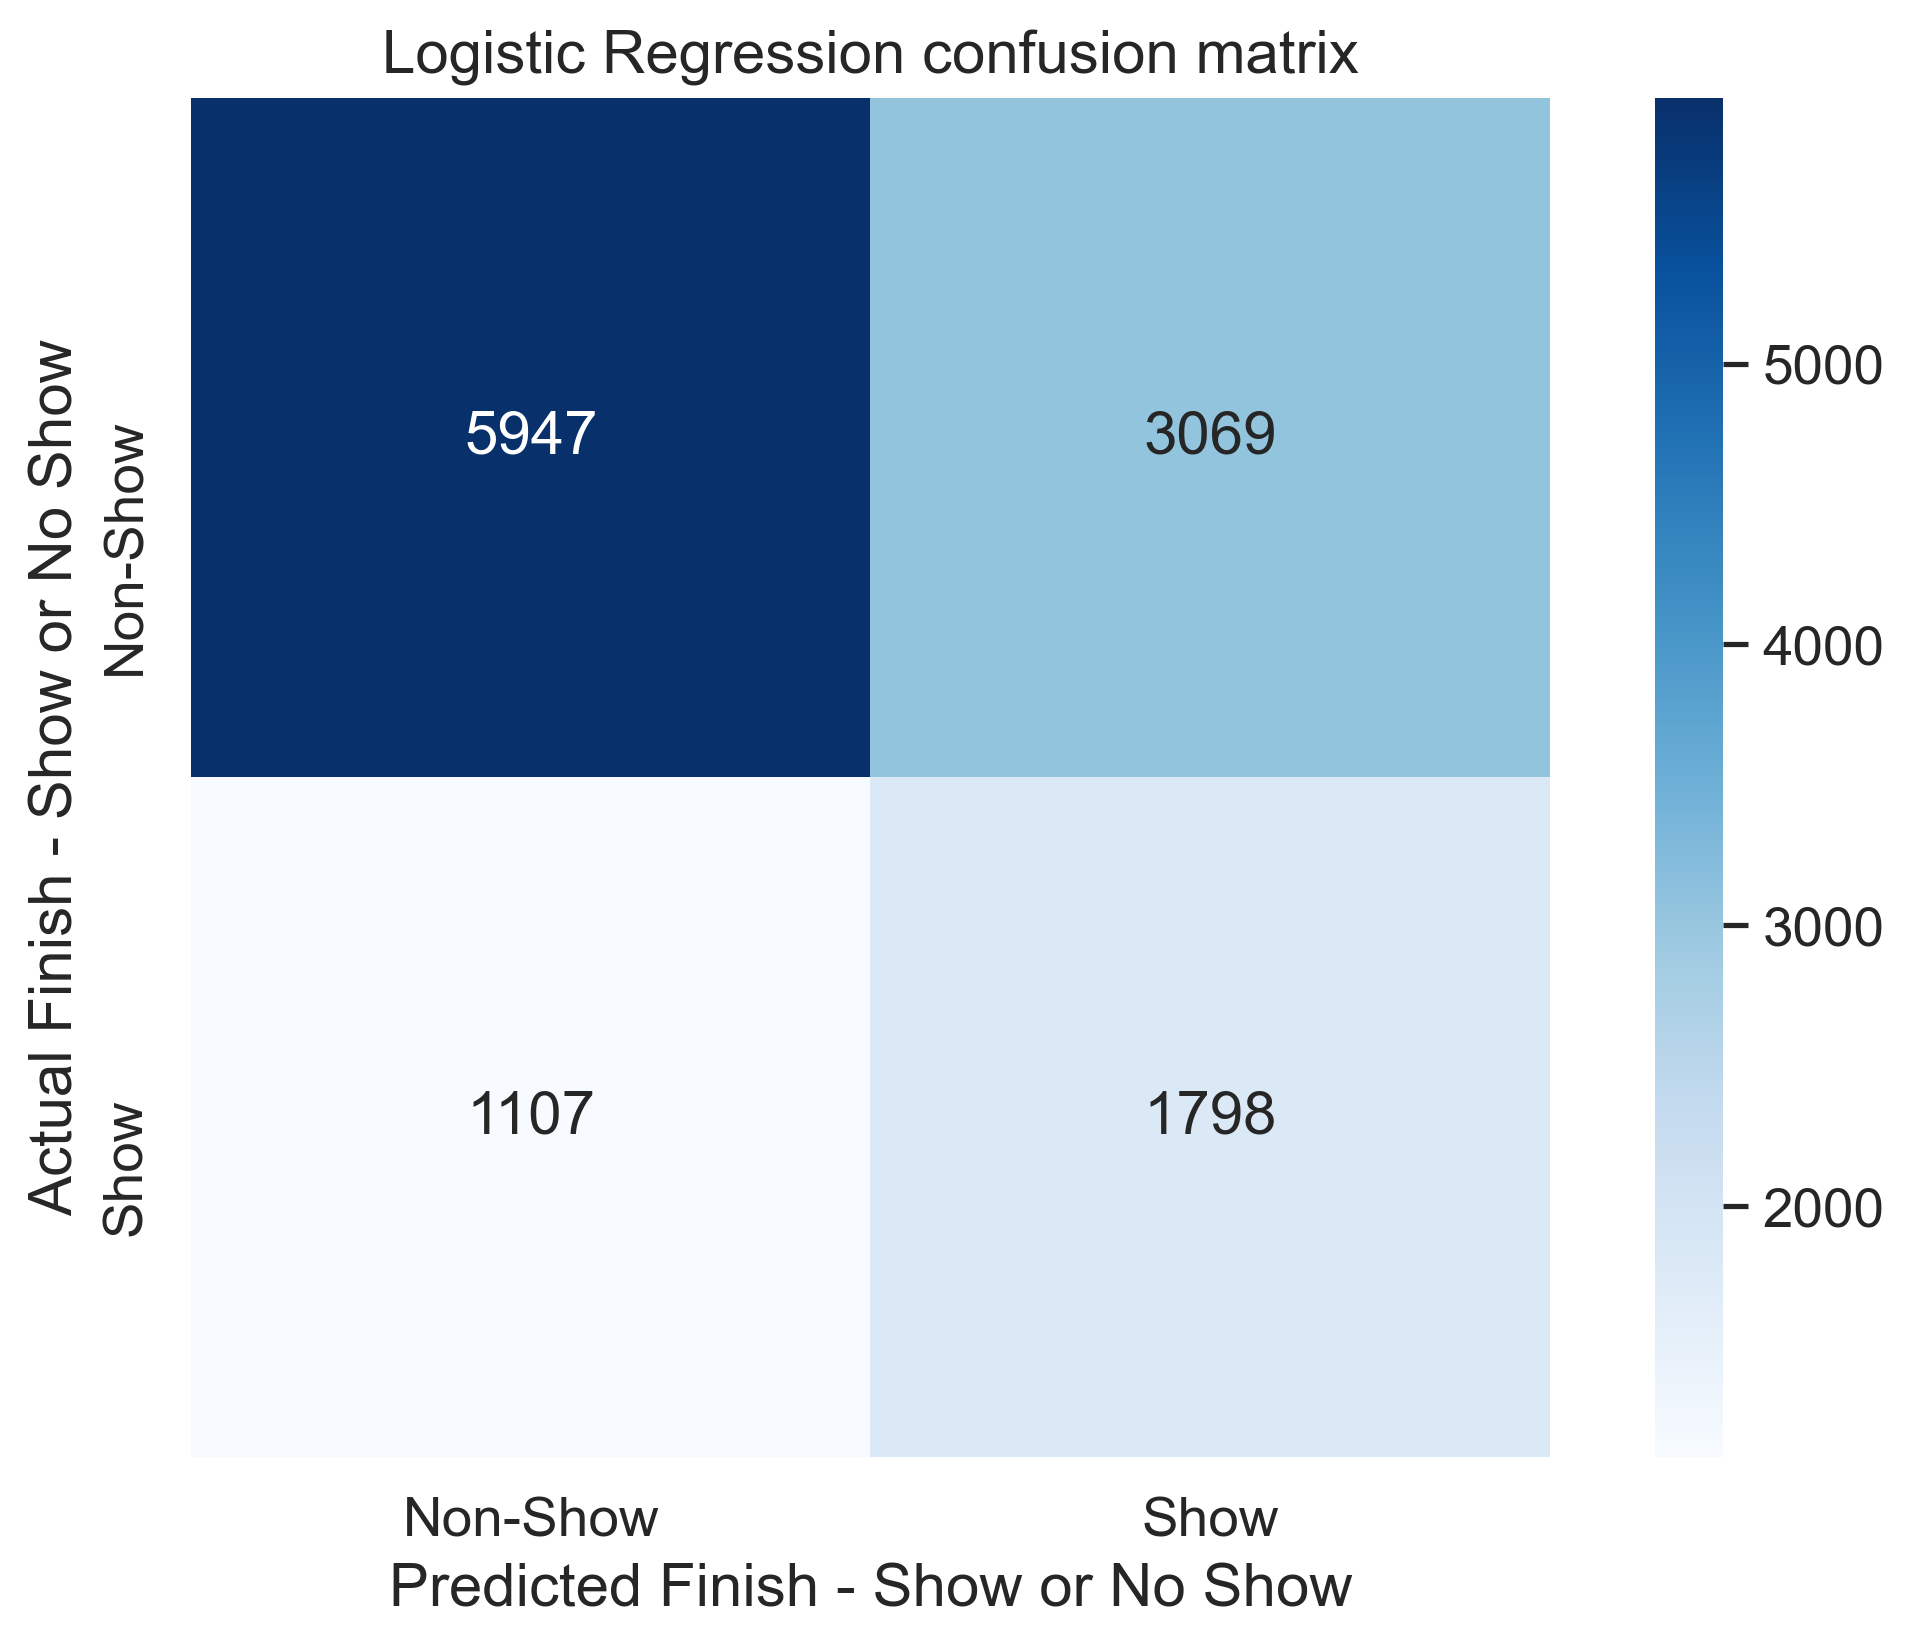

In [46]:
for c in C_list:
    log_accuracy_scorer(X, y, threshold=0.2508, C=c, beta=0.5)

Based on above, running with C of 1:

In [47]:
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5]

The accuracy score for logistic regression w/ threshold of 0.1 is:
Validation set accuracy:  33.71%
Additional Model Metrics:
Validation Set F1 Score: 0.4179:
Validation Set Fbeta Score (beta=0.5): 0.3111
Validation set Precision: 0.2658
Validation set recall: 0.9762 

Validation set log-loss score: 22.8950
Confusion Matrix, Threshold = 0.1
The accuracy score for logistic regression w/ threshold of 0.2 is:
Validation set accuracy:  56.67%
Additional Model Metrics:
Validation Set F1 Score: 0.4624:
Validation Set Fbeta Score (beta=0.5): 0.3737
Validation set Precision: 0.3314
Validation set recall: 0.7645 

Validation set log-loss score: 14.9649
Confusion Matrix, Threshold = 0.2
The accuracy score for logistic regression w/ threshold of 0.3 is:
Validation set accuracy:  70.19%
Additional Model Metrics:
Validation Set F1 Score: 0.4382:
Validation Set Fbeta Score (beta=0.5): 0.4177
Validation set Precision: 0.4051
Validation set recall: 0.4771 

Validation set log-loss score: 10.2972
Confu

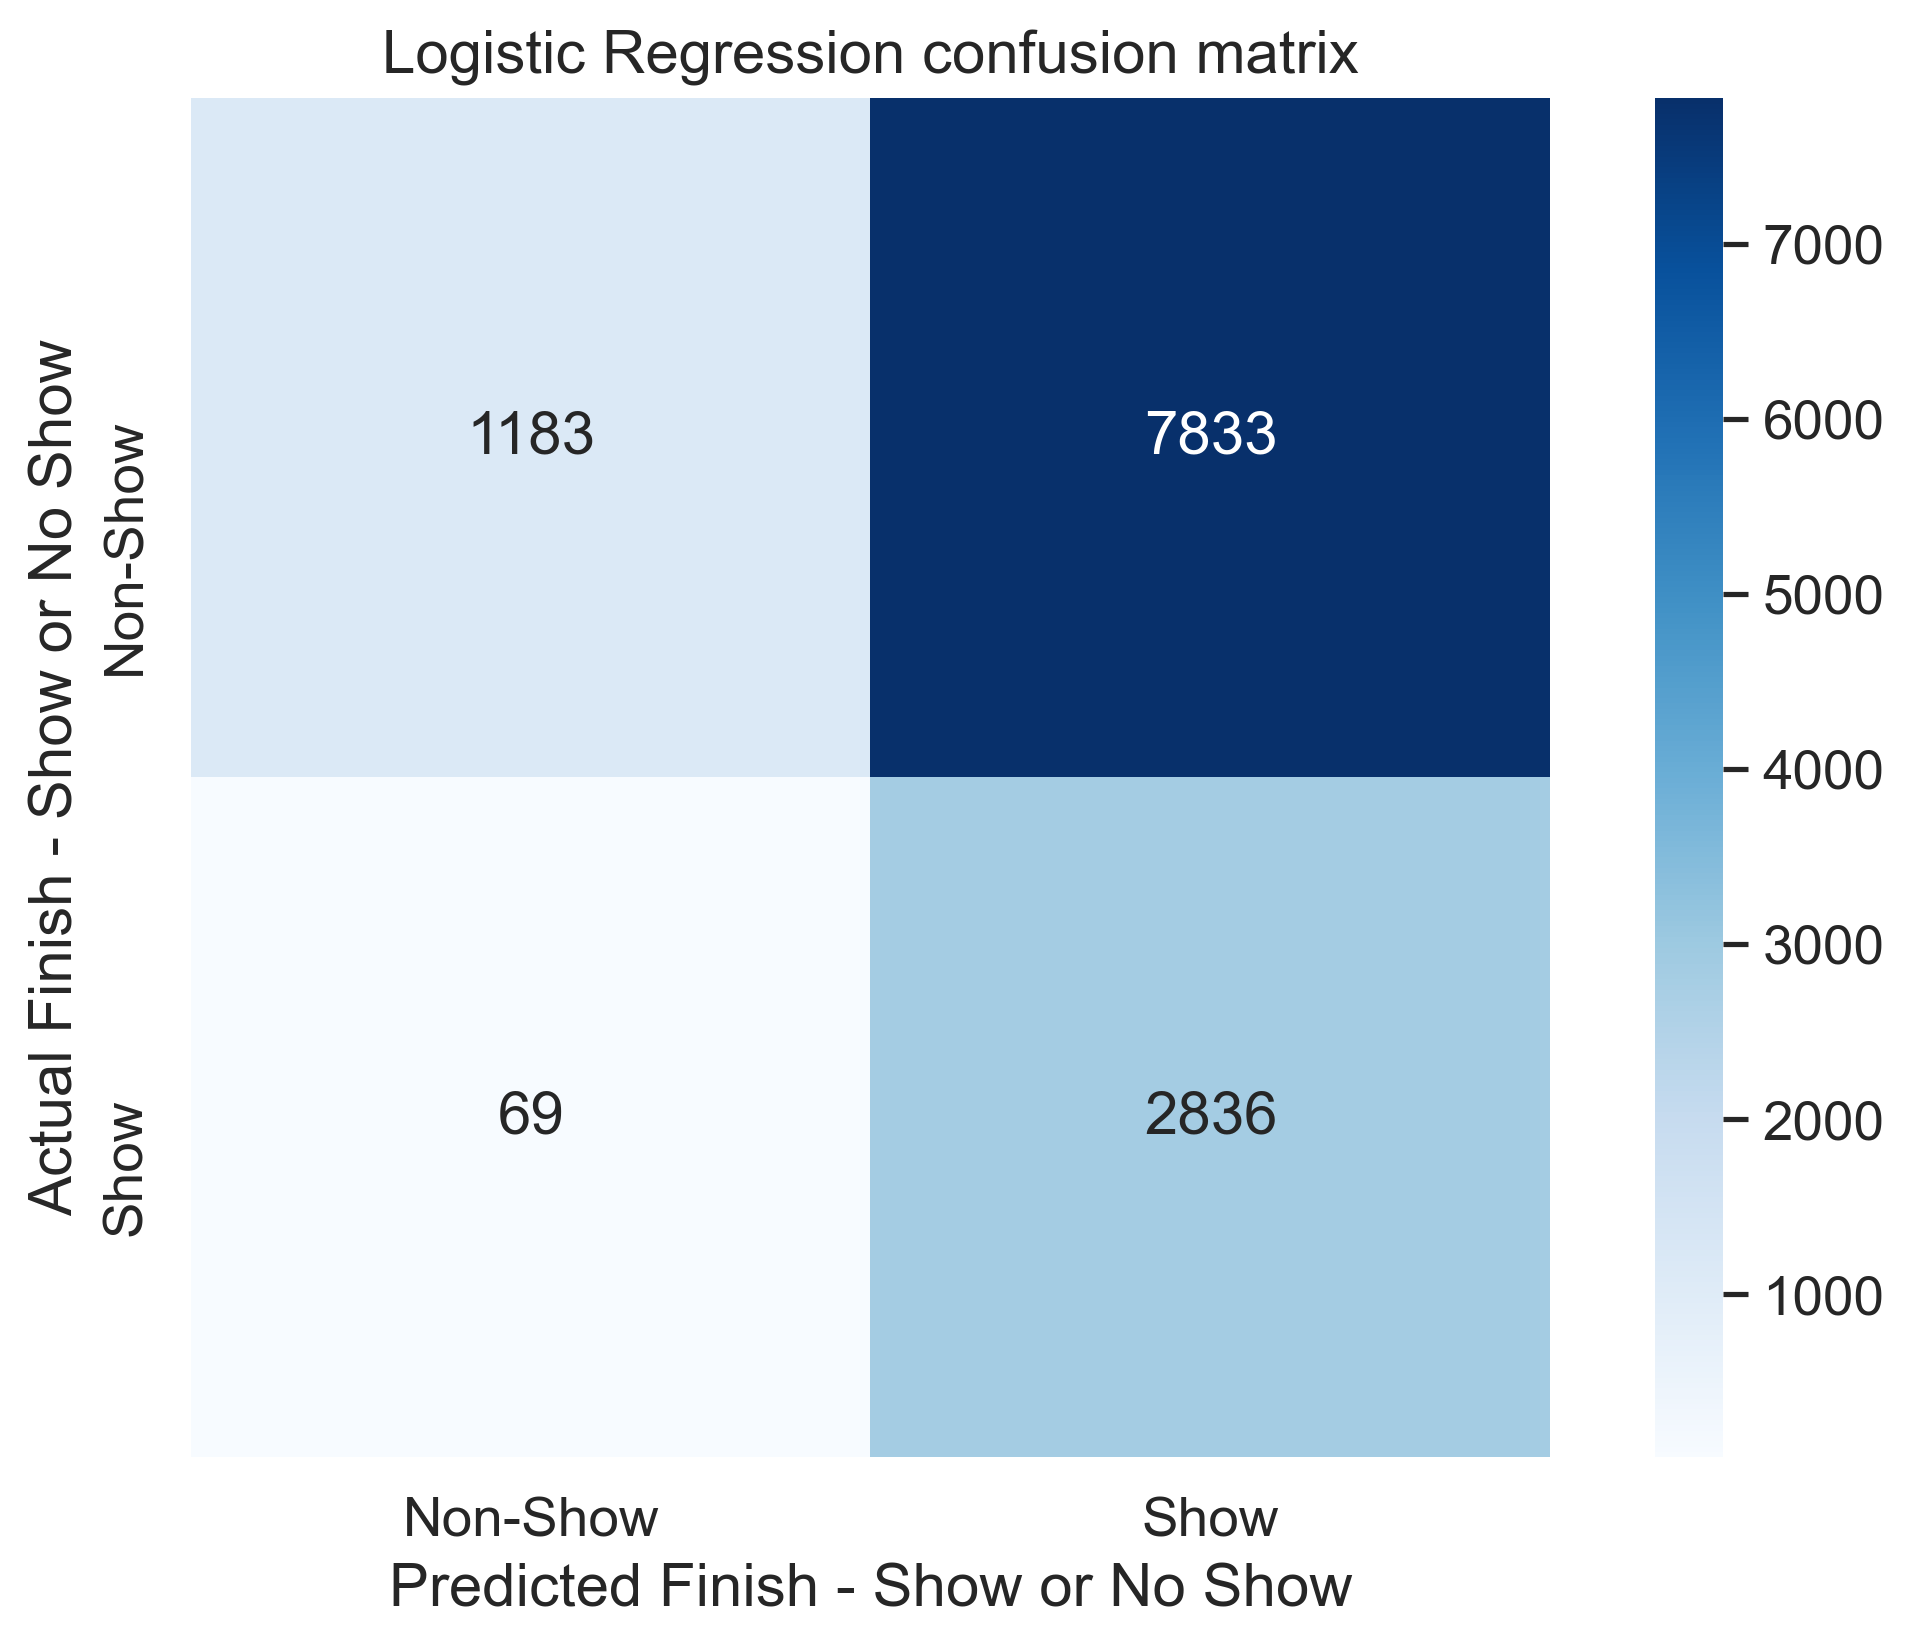

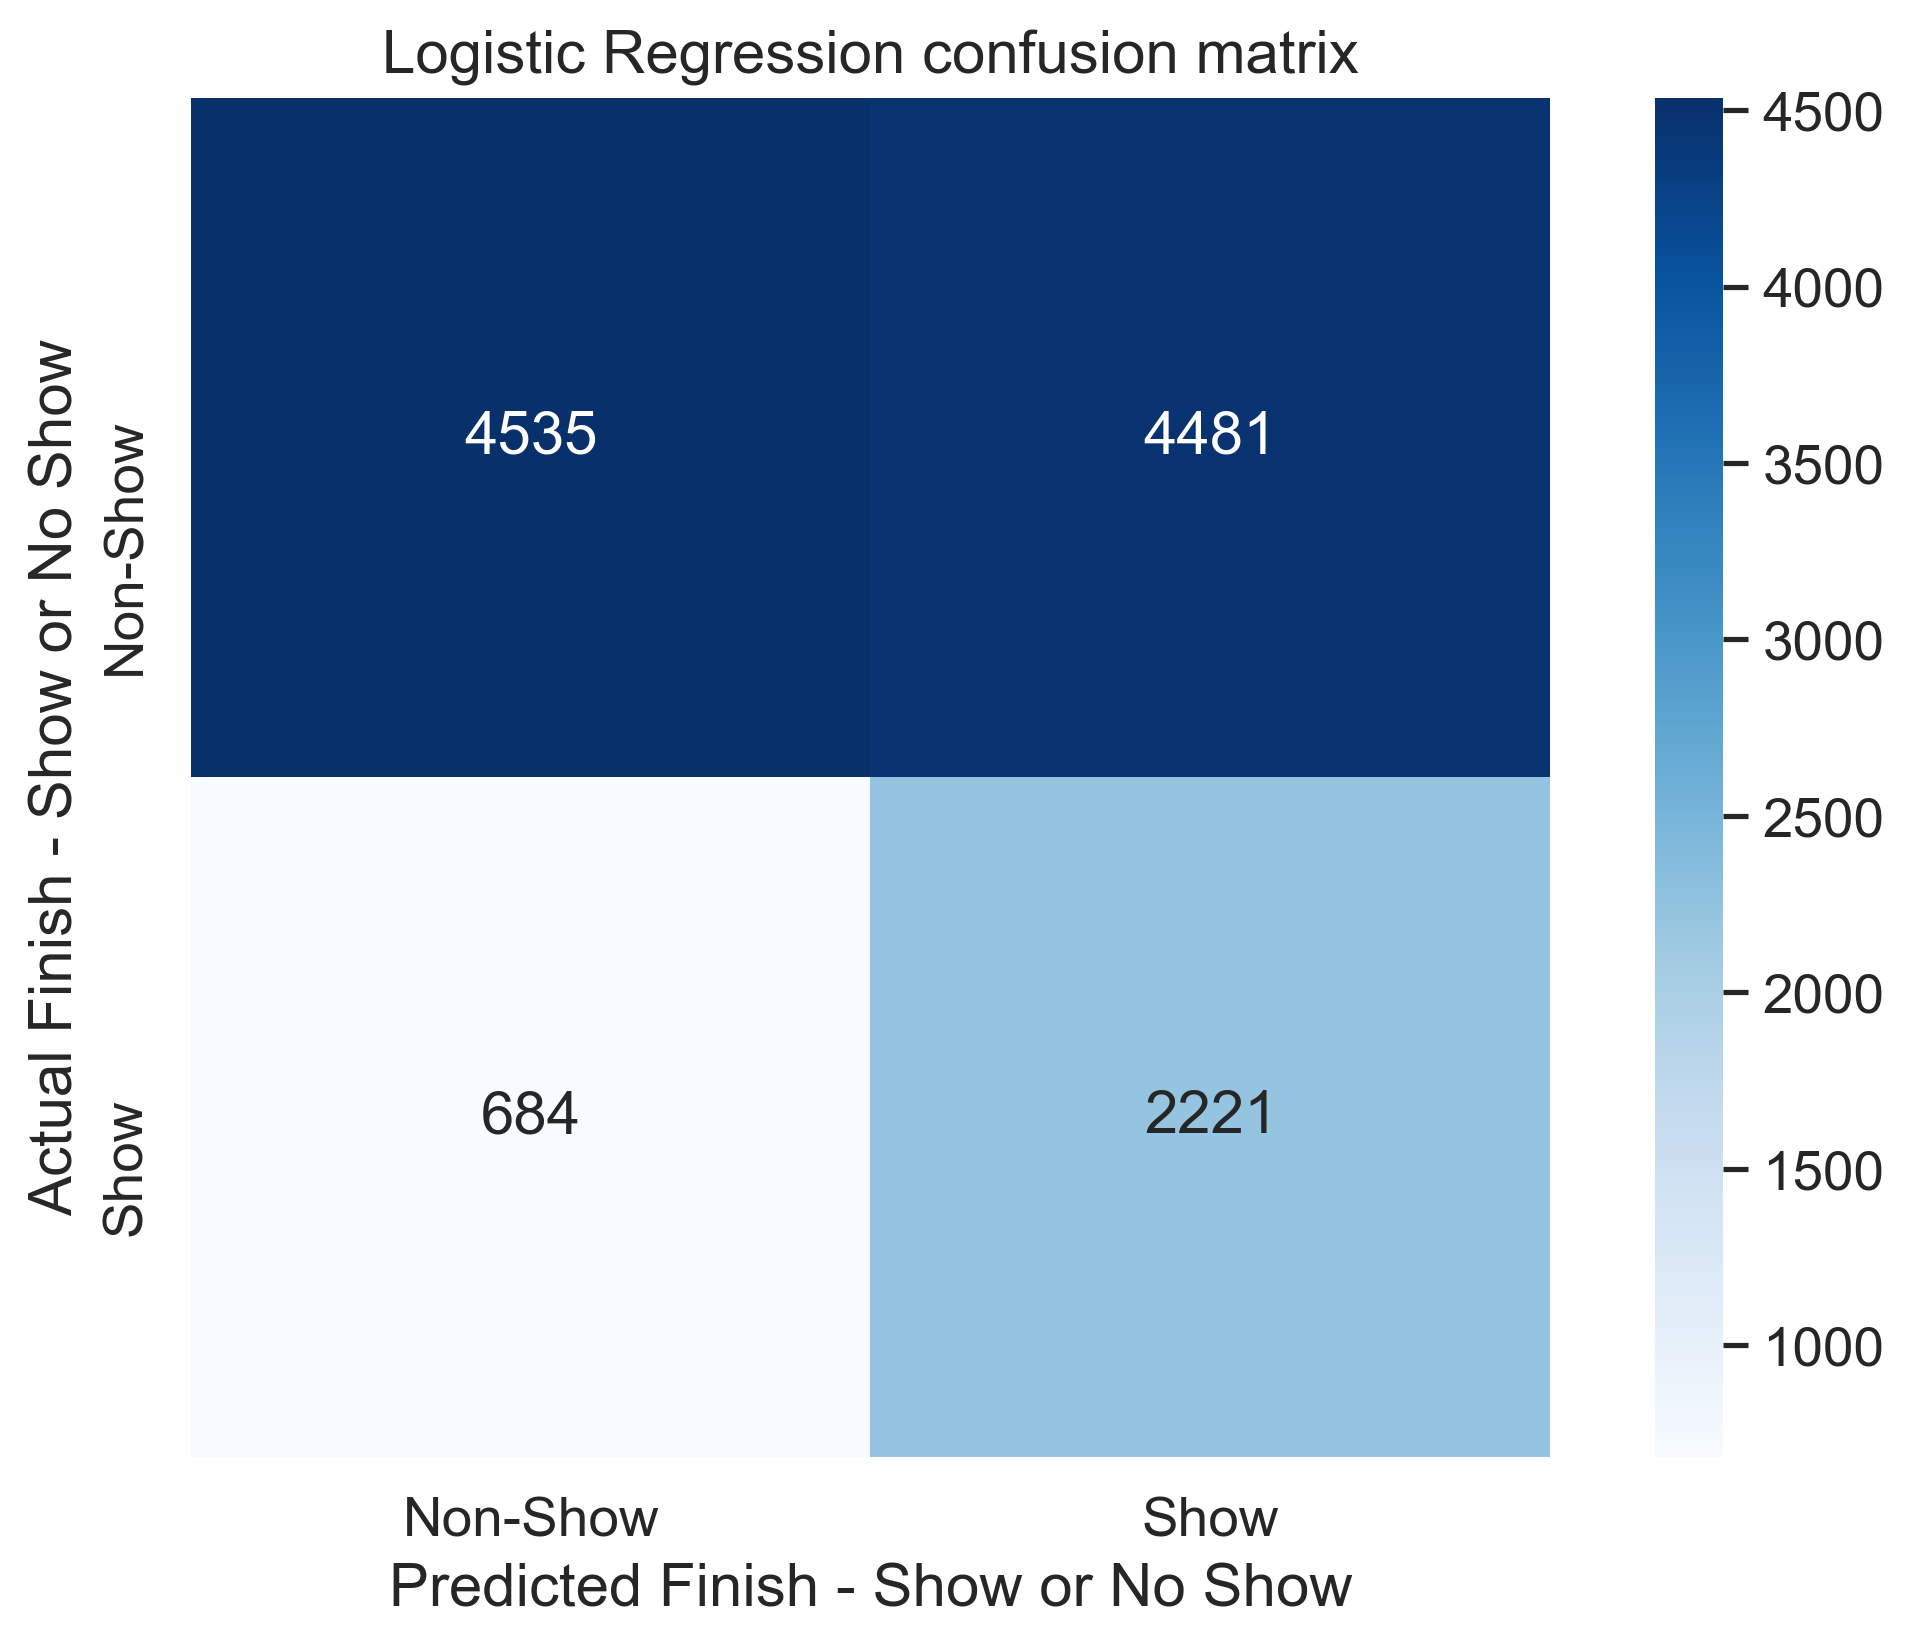

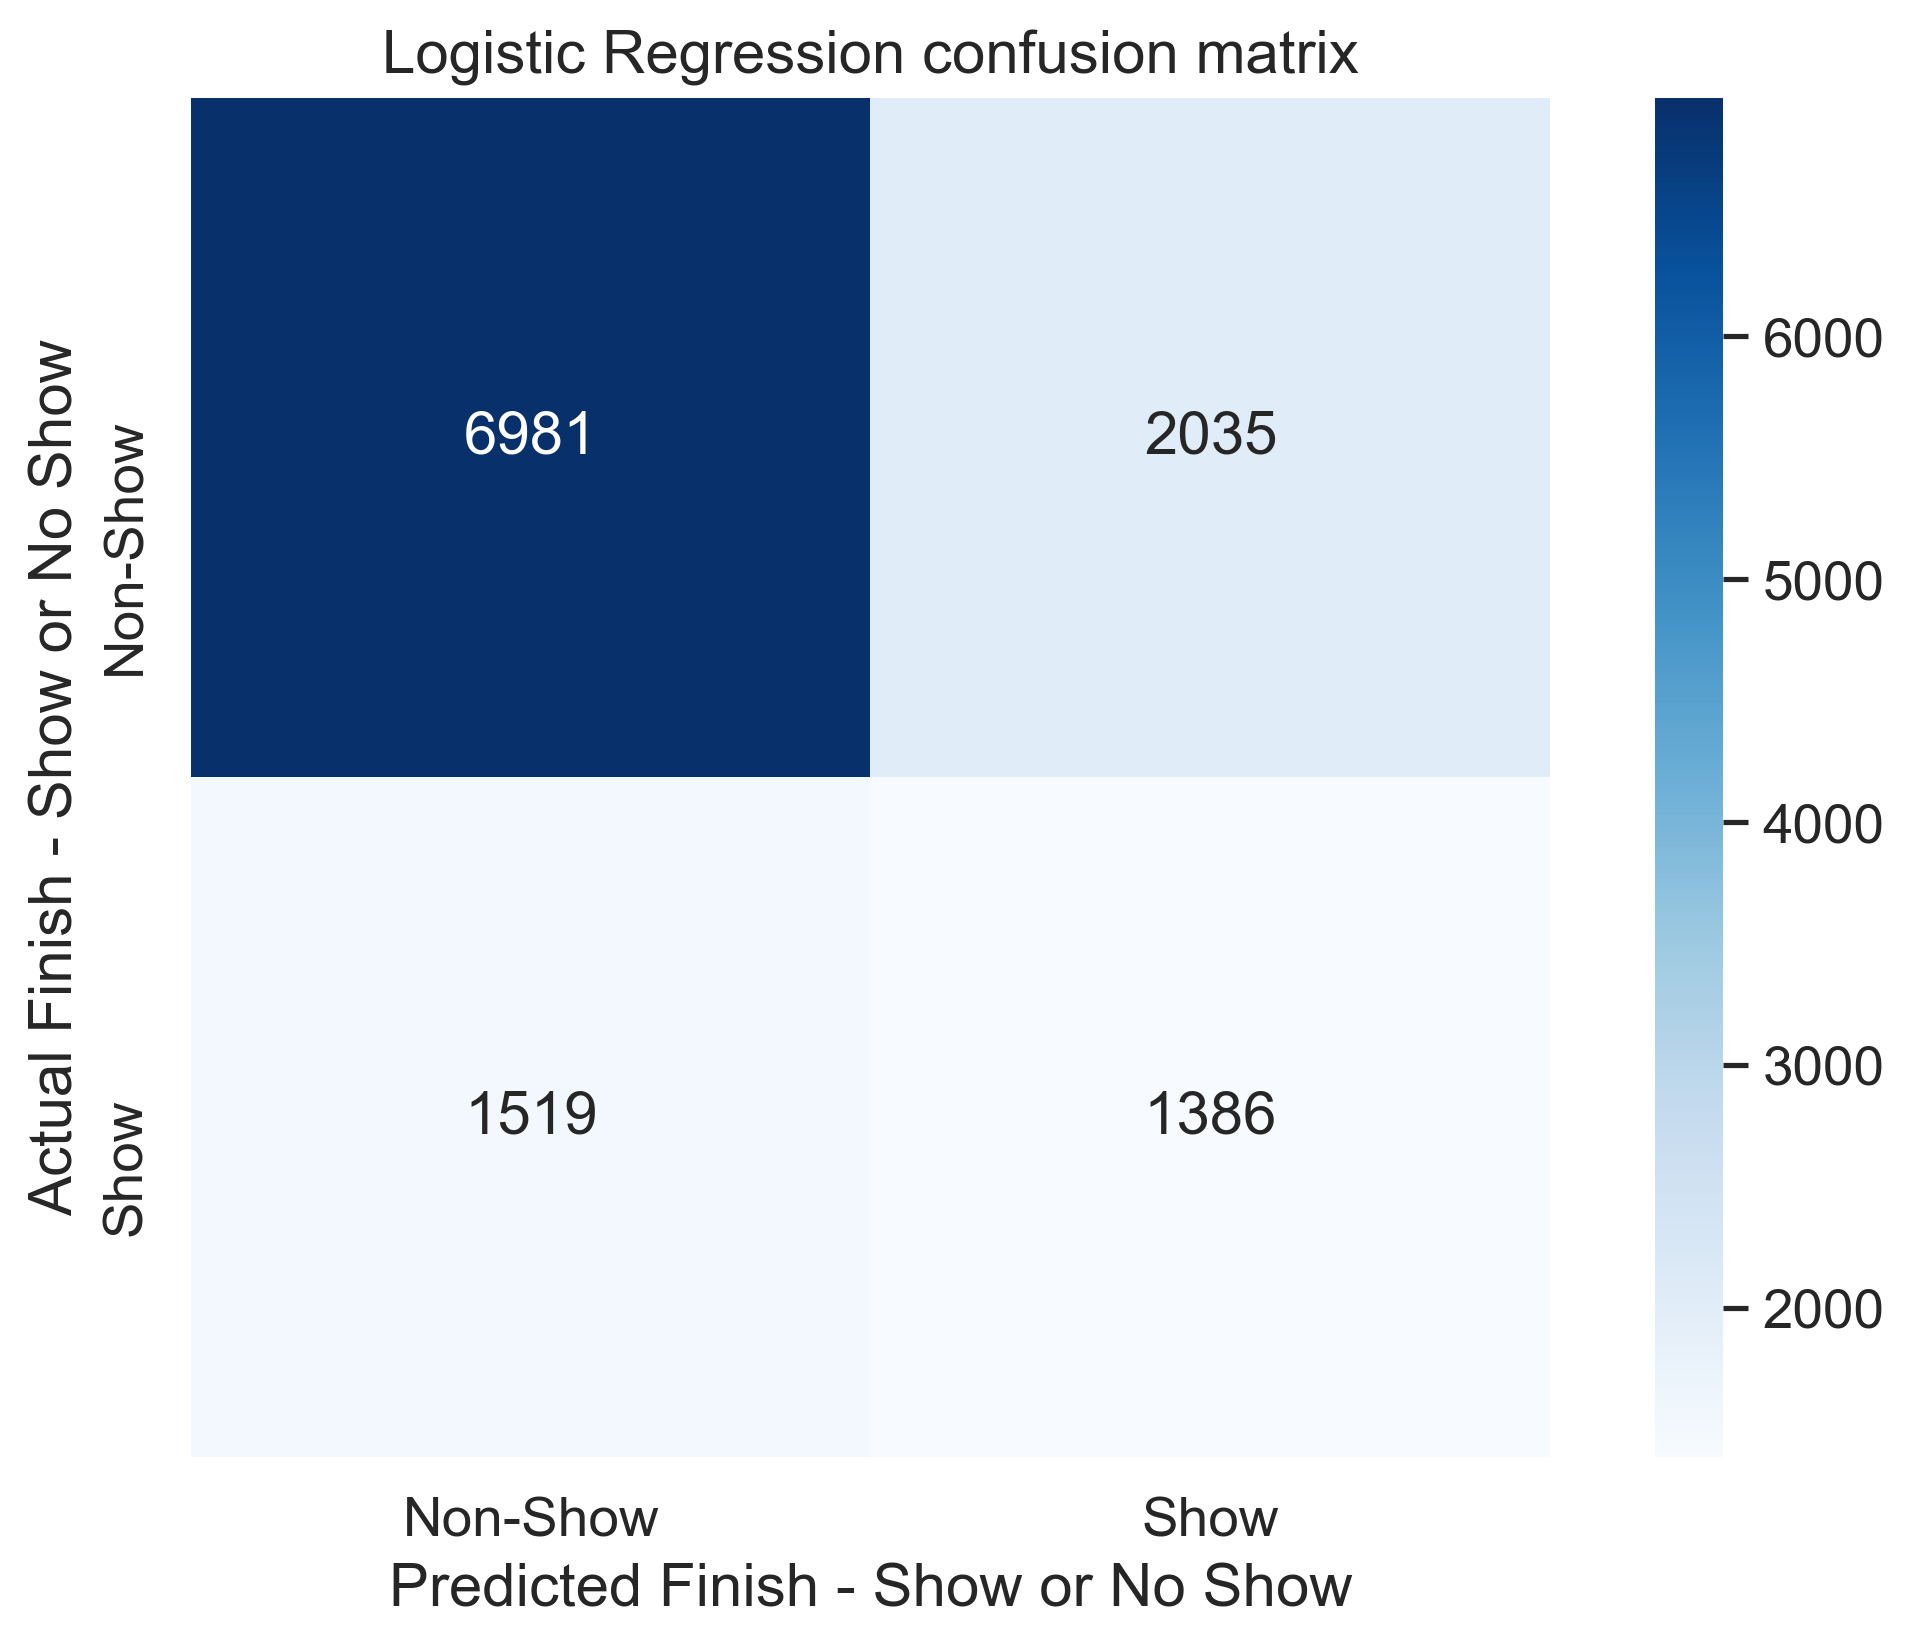

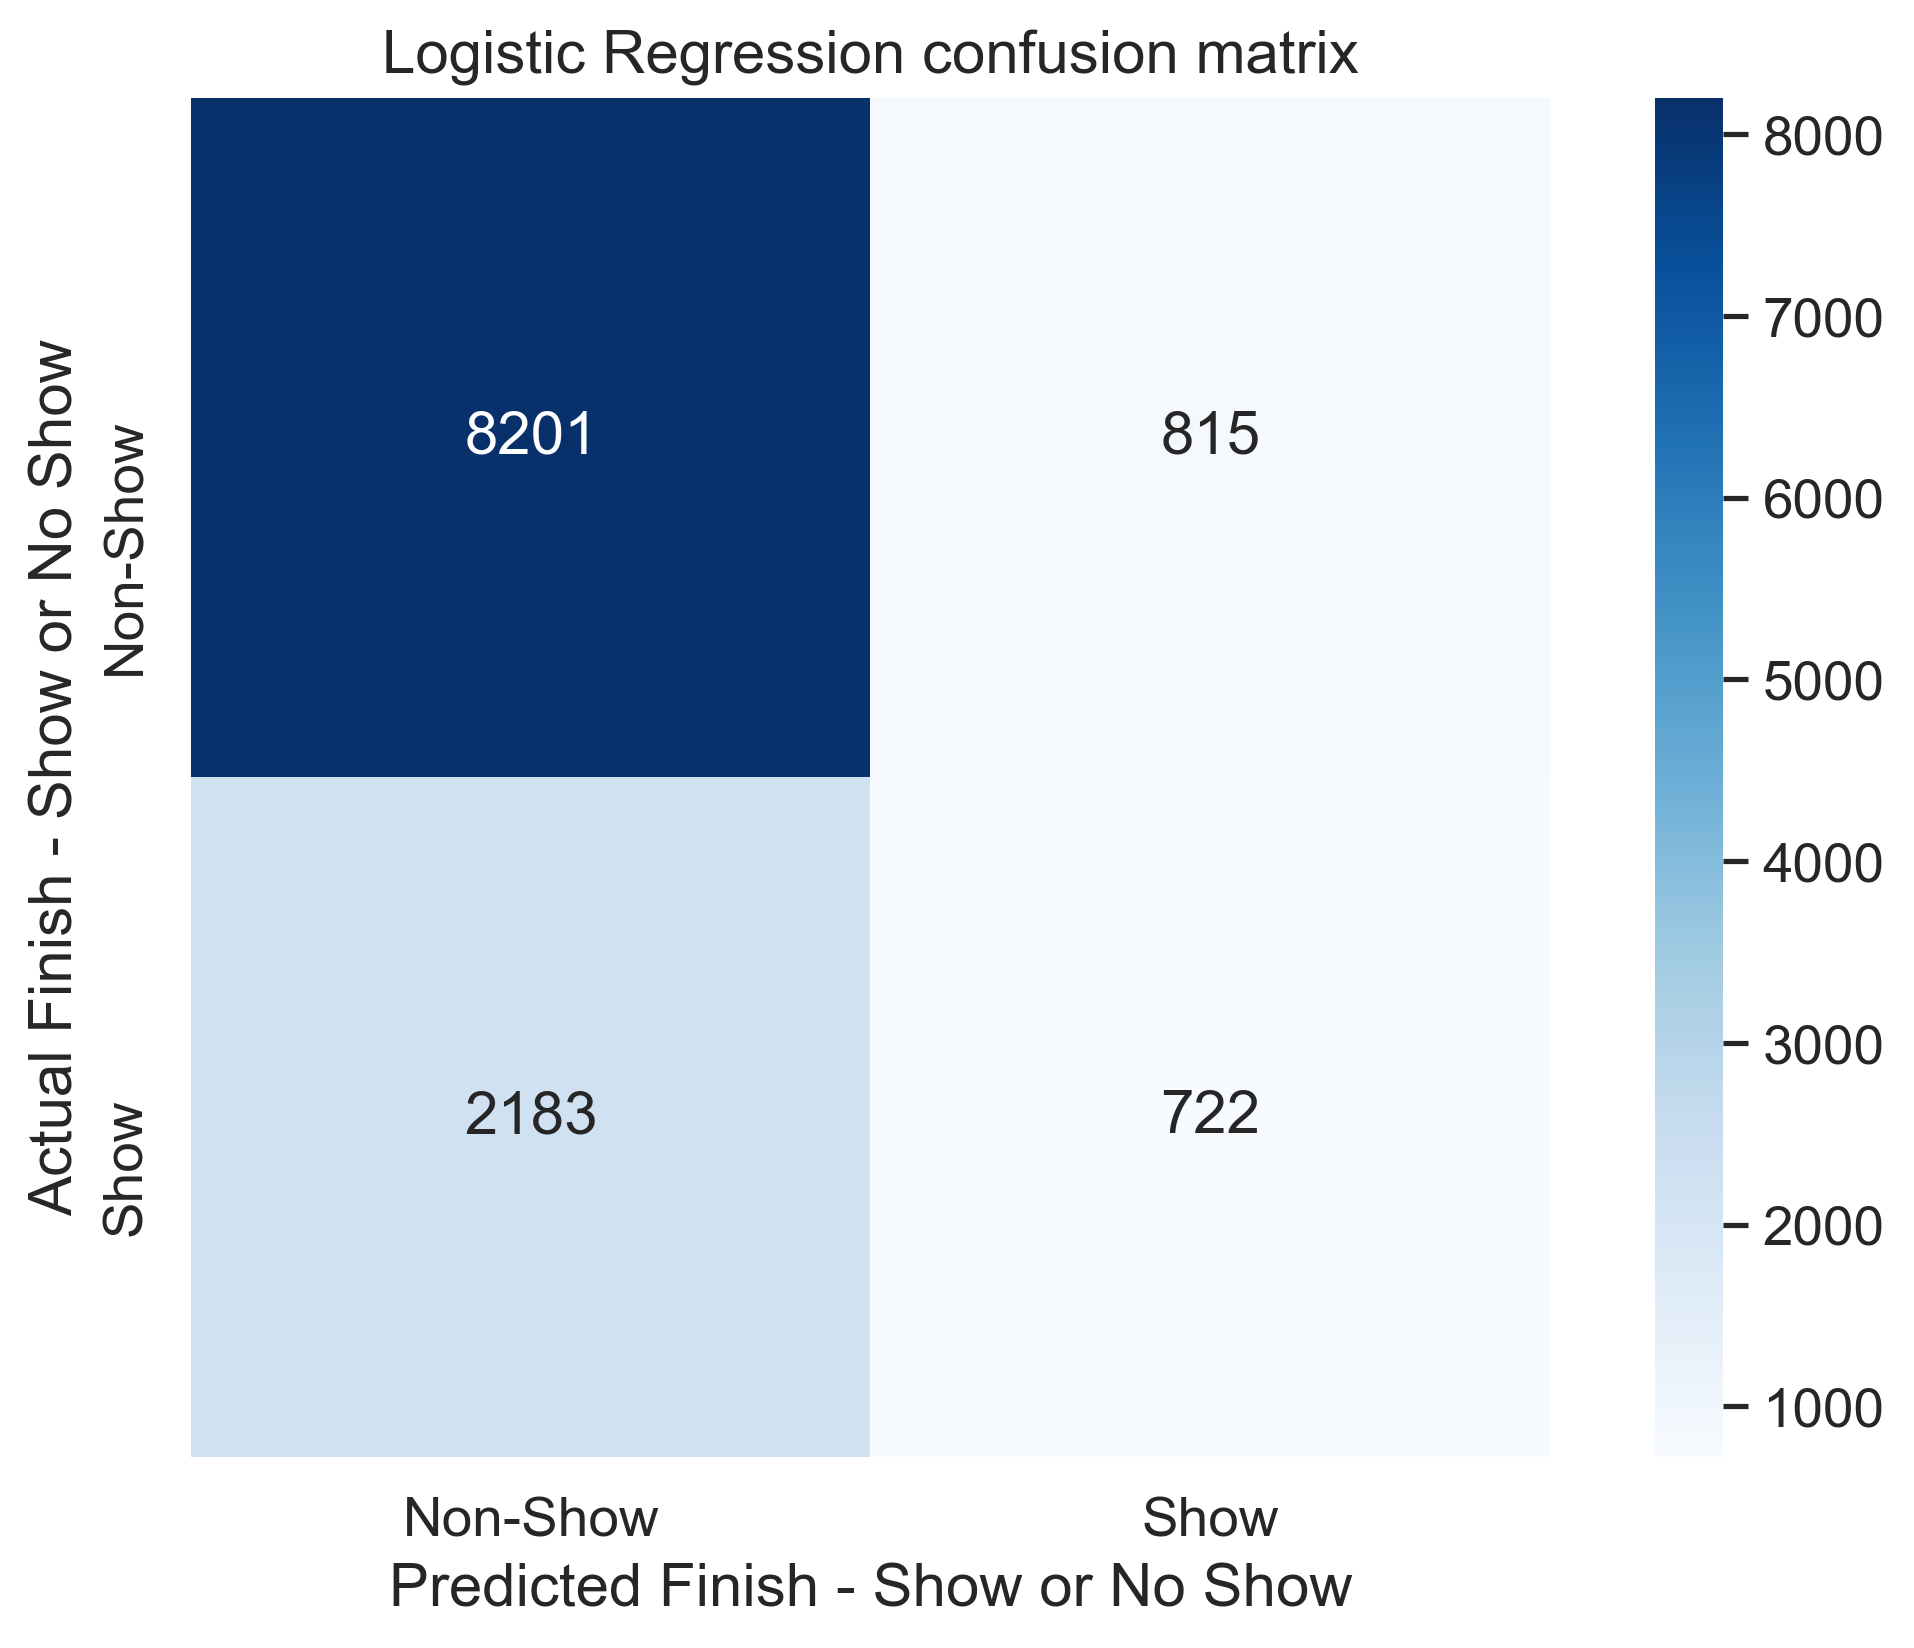

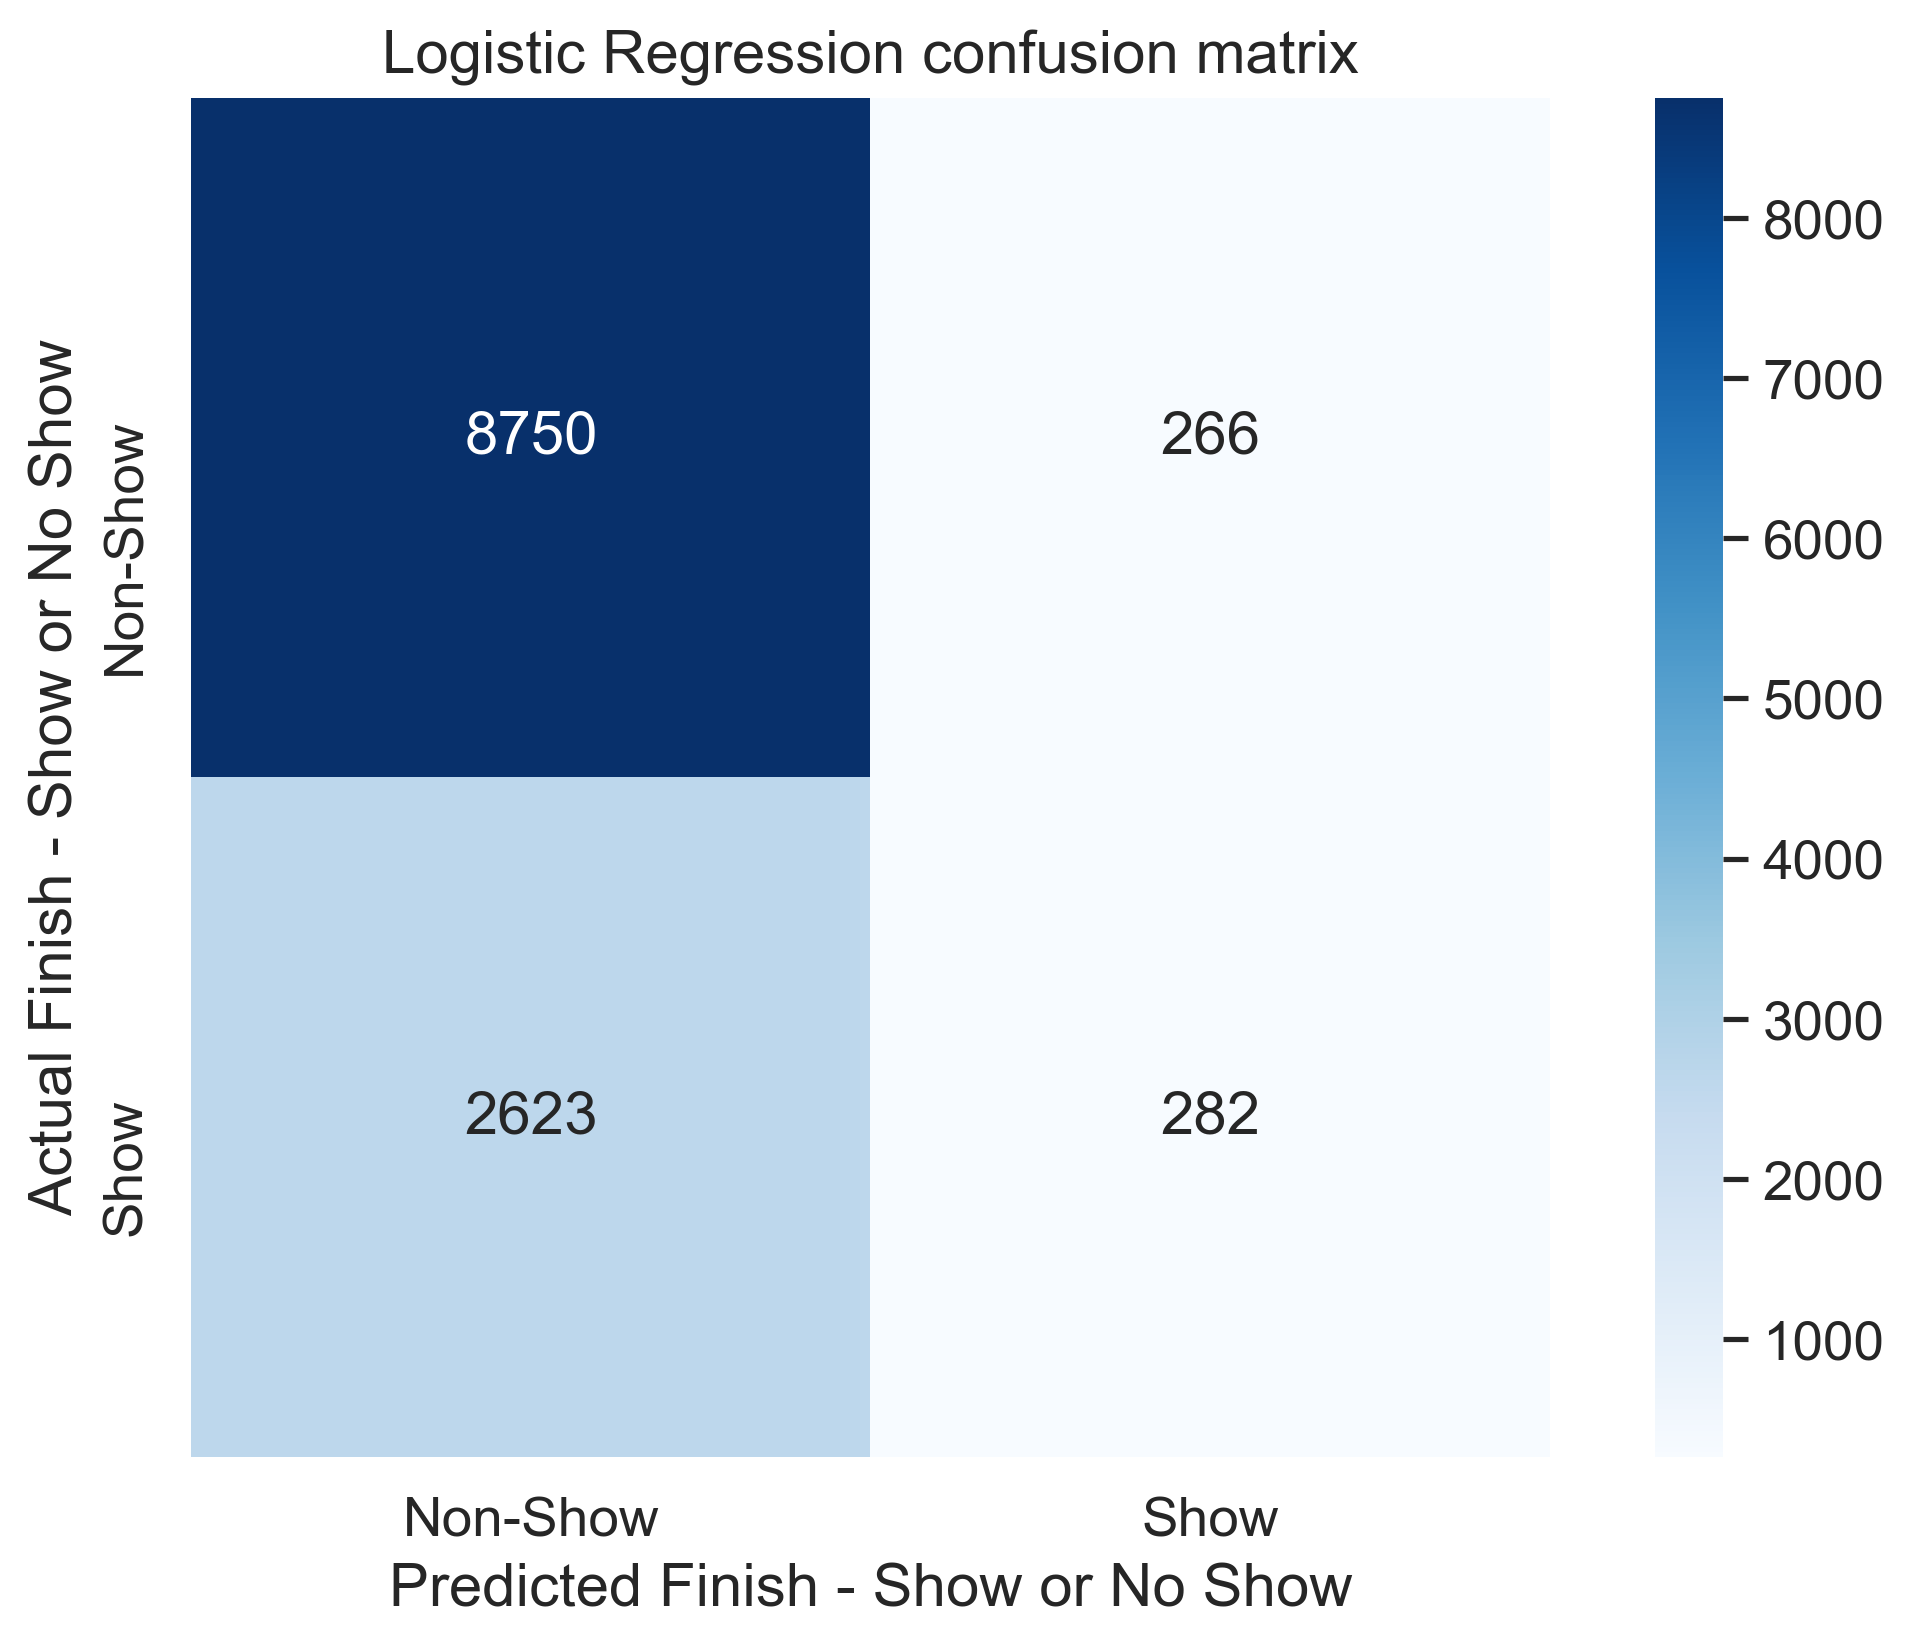

In [48]:
for t in threshold_list:
    log_accuracy_scorer(X, y, threshold=t, C=1, beta=0.5)

With increasing threshold, precision goes up, but the number of predictions continues to go down.  With C, there seems to be a sweet spot over 1.

Threshold ultimately can depend on how risk-averse someone is when gambling.

# Updated Functions - Adding K Fold Cross Validation (Above is simple train/validation split):

## Logistic Regression:

Function is log_accuracy_scorer_k_fold from logistic_reg_model_eval.py

In [62]:
X = comb_training_horses_2_cleaned[columns_1]
y = comb_training_horses_2_cleaned['show']

In [66]:
log_accuracy_scorer_k_fold(X, y, k=5, threshold=0.5, C=1)

Logistic Regression Classification w/ KFOLD CV Results (k=5):
Log. Reg Accuracy scores:  [0.757570673601208, 0.7595839275228589, 0.7617649526046473, 0.7573190168610016, 0.7664625450884993] 

Simple mean cv accuracy: 0.761 + 0.003 

Log. Reg Precision scores:  [0.5244122965641953, 0.5484429065743944, 0.5491525423728814, 0.5530434782608695, 0.5456204379562044] 

Simple mean cv precision: 0.544 +- 0.010 

Log. Reg Recall scores:  [0.09941720946177579, 0.10848733744010951, 0.11180124223602485, 0.10765064319566689, 0.10550458715596331] 

Simple mean cv recall: 0.107 +- 0.004 

Log. Reg Fbeta (beta=0.5) scores:  [0.28270618054201596, 0.3028276652655712, 0.3081019399011031, 0.3026265702322041, 0.2974532431356944] 

Simple mean cv Fbeta (beta=0.5): 0.299 +- 0.009 

Log. Reg F1 scores:  [0.16714697406340057, 0.1811428571428571, 0.18577981651376146, 0.18022102578634175, 0.17681845062093438] 

Simple mean cv F1: 0.178 +- 0.006 

Log. Reg Log Loss scores:  [8.373229936701286, 8.30369447552582, 8.2

LogisticRegression(C=1)

## KNN w/ K-Fold Cross Val

Function in knn_model_eval.py

In [64]:
X = comb_training_horses_2_cleaned[columns_1]
y = comb_training_horses_2_cleaned['show']

In [65]:
KNN_accuracy_scorer_f_fold(X, y, n = 21, k=5)

KNN Classification w/ KFOLD CV Results (k=5):
KNN Accuracy scores:  [0.755557419679557, 0.7568157033805889, 0.754383021558594, 0.748930458854123, 0.7607583256438218] 

Simple mean cv accuracy: 0.755 + 0.004 

KNN Precision scores:  [0.502177068214804, 0.5161290322580645, 0.4789915966386555, 0.47218259629101283, 0.486646884272997] 

Simple mean cv precision: 0.491 +- 0.016 

KNN Recall scores:  [0.11861501542680837, 0.12594113620807665, 0.11801242236024845, 0.11205145565335138, 0.11573747353563868] 

Simple mean cv recall: 0.118 +- 0.005 

KNN Fbeta (beta=0.5) scores:  [0.3049532875022034, 0.31866989954970554, 0.29718456725755993, 0.2874261896491837, 0.2965641952983726] 

Simple mean cv Fbeta (beta=0.5): 0.301 +- 0.010 

KNN F1 scores:  [0.19190238491403216, 0.2024759284731774, 0.18936877076411962, 0.1811217510259918, 0.1870011402508552] 

Simple mean cv F1: 0.190 +- 0.007 



KNeighborsClassifier(n_neighbors=21)